# Set up environment

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import os

import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, cross_validate




from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier




pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/Users/Internship/Documents/GitHub/Capstone_Notebook/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Loading the datasets into dataframes

In [2]:
df_fridayAF_DDos = pd.read_csv("./datasets/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df_fridayAF_PortScan = pd.read_csv("./datasets/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df_fridayMO = pd.read_csv("./datasets/Friday-WorkingHours-Morning.pcap_ISCX.csv")
df_monday = pd.read_csv("./datasets/Monday-WorkingHours.pcap_ISCX.csv")
df_thursdayAF_Infilteration = pd.read_csv("./datasets/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df_thursdayMO_WebAttacks = pd.read_csv("./datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df_tuesday = pd.read_csv("./datasets/Tuesday-WorkingHours.pcap_ISCX.csv")
df_wednesday = pd.read_csv("./datasets/Wednesday-workingHours.pcap_ISCX.csv")

# Concatenating the dataframes to single dataframe

In [3]:
df_data = pd.concat([df_fridayAF_DDos,df_fridayAF_PortScan,df_fridayMO,df_monday,df_thursdayAF_Infilteration,df_thursdayMO_WebAttacks,df_tuesday,df_wednesday], axis=0,ignore_index=True)

## The label column is know to be the target
## All the prvious columns are the feature matrix

In [4]:
df_data.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
df_data.describe()

/Users/Internship/Documents/GitHub/Capstone_Notebook/env/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/Internship/Documents/GitHub/Capstone_Notebook/env/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.829385e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2830743.0,2.830743e+06,2830743.0,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2830743.0,2830743.0,2830743.0,2830743.0,2830743.0,2830743.0,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,8.708495e+02,4.104958e+01,3.059493e+02,3.353257e+02,inf,inf,1.298449e+06,2.919271e+06,9.182475e+06,1.623796e+05,1.448296e+07,2.610193e+06,3.266957e+06,9.042939e+06,1.021893e+06,9.893830e+06,1.805784e+06,1.485973e+06,4.684692e+06,9.672614e+05,4.644646e-02,0.0,1.112782e-04,0.0,-2.599739e+04,-2.273275e+03,6.386535e+04,6.995192e+03,1.643450e+01,9.504024e+02,1.719444e+02,2.949756e+02,4.861548e+05,3.537976e-02,4.644646e-02,2.423392e-04,2.980705e-01,3.158443e-01,9.482316e-02,1.112782e-04,2.433990e-04,6.835004e-01,1.919837e+02,5.820194e+01,3.059493e+02,-2.599739e+04,0.0,0.0,0.0,0.0,0.0,0.0,9.361160e+00,5.492919e+02,1.039377e+01,1.616230e+04,6.989837e+03,1.989433e+03,5.418218e+00,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,1.946367e+03,6.886260e+01,6.052568e+02,8.396932e+02,NaN,NaN,4.507944e+06,8.045870e+06,2.445954e+07,2.950282e+06,3.357581e+07,9.525722e+06,9.639055e+06,2.452916e+07,8.591436e+06,2.873661e+07,8.887197e+06,6.278469e+06,1.716095e+07,8.308983e+06,2.104500e-01,0.0,1.054826e-02,0.0,2.105286e+07,1.452209e+06,2.475371e+05,3.815170e+04,2.523772e+01,2.028229e+03,3.054915e+02,6.318001e+02,1.647490e+06,1.847378e-01,2.104500e-01,1.556536e-02,4.574107e-01,4.648513e-01,2.929706e-01,1.054826e-02,1.559935e-02,6.804920e-01,3.318603e+02,1.860912e+02,6.052568e+02,2.105286e+07,0.0,0.0,0.0,0.0,0.0,0.0,7.496728e+02,9.980070e+03,9.973883e+02,2.26305

#### we can notice from the above results that we have an outliers in the columns of Flow Bytes/s since the min has negative values

# Data Preprocessing

#### Find columns with zero variance; columns where all values are the same


In [6]:
zero_variance_cols = [col for col in df_data.columns if df_data[col].nunique() == 1]

# Display the columns with zero variance
if zero_variance_cols:
    print(f"Columns with zero variance: {zero_variance_cols}")
else:
    print("No columns with zero variance found.")

Columns with zero variance: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


##### Shape before removing zero variance columns

In [7]:
print('Shape before removing zero variance columns:', df_data.shape)

Shape before removing zero variance columns: (2830743, 79)


#### Handle columns with zero variance

In [8]:
if zero_variance_cols:
        df_data.drop(zero_variance_cols, axis=1, inplace=True)
        print(f'Dropped zero variance columns: {zero_variance_cols}')

Dropped zero variance columns: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


##### Shape after removing zero variance columns

In [9]:
print('Shape after removing zero variance columns:', df_data.shape)

Shape after removing zero variance columns: (2830743, 71)


#### Find  spaces from column names

In [10]:
df_data.keys()

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SYN Flag Count', 

##### Handle spaces from column names

In [11]:
df_data.columns = df_data.columns.str.strip()

#### Columns after removing spaces

In [12]:
df_data.keys()

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',

### Identify Rows with NaN, inf, or -inf Values
##### The row listed here contain  NaN ( Not a number) across the columns displayed.

In [13]:
# Select only numeric columns
numeric_cols = df_data.select_dtypes(include=[np.number])

# Check for inf and -inf values in the numeric columns
inf_values = np.isinf(numeric_cols).sum()

# Display the count of inf and -inf values in each numeric column
print("Count of inf and -inf values in each numeric column:")
print(inf_values)

Count of inf and -inf values in each numeric column:
Destination Port                  0
Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
Fwd Packet Length Max             0
Fwd Packet Length Min             0
Fwd Packet Length Mean            0
Fwd Packet Length Std             0
Bwd Packet Length Max             0
Bwd Packet Length Min             0
Bwd Packet Length Mean            0
Bwd Packet Length Std             0
Flow Bytes/s                   1509
Flow Packets/s                 2867
Flow IAT Mean                     0
Flow IAT Std                      0
Flow IAT Max                      0
Flow IAT Min                      0
Fwd IAT Total                     0
Fwd IAT Mean                      0
Fwd IAT Std                       0
Fwd IAT Max                       0
Fwd IAT Min                       0
Bwd IAT Total                     0
Bwd IAT Mea

### Replace inf and -inf with Nan

In [14]:
df_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [15]:
df_data.isna().sum()

Destination Port                  0
Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
Fwd Packet Length Max             0
Fwd Packet Length Min             0
Fwd Packet Length Mean            0
Fwd Packet Length Std             0
Bwd Packet Length Max             0
Bwd Packet Length Min             0
Bwd Packet Length Mean            0
Bwd Packet Length Std             0
Flow Bytes/s                   2867
Flow Packets/s                 2867
Flow IAT Mean                     0
Flow IAT Std                      0
Flow IAT Max                      0
Flow IAT Min                      0
Fwd IAT Total                     0
Fwd IAT Mean                      0
Fwd IAT Std                       0
Fwd IAT Max                       0
Fwd IAT Min                       0
Bwd IAT Total                     0
Bwd IAT Mean                      0
Bwd IAT Std                 

### Check for empty strings or negative values in Flow Bytes/s

In [16]:
sub_df = df_data[df_data['Flow Bytes/s'].isna() | (df_data['Flow Bytes/s'] == '') | (df_data['Flow Bytes/s'] < 0)]
sub_df['Label'].value_counts()

Label
BENIGN         1862
DoS Hulk        949
PortScan        126
Bot              10
FTP-Patator       3
DDoS              2
Name: count, dtype: int64

In [17]:
print("Check for NaN values in Label column:", df_data['Label'].isna().sum())

Check for NaN values in Label column: 0


In [18]:
df_data['Label'].value_counts()

Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [19]:
print(df_data.isna().sum())

Destination Port                  0
Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
Fwd Packet Length Max             0
Fwd Packet Length Min             0
Fwd Packet Length Mean            0
Fwd Packet Length Std             0
Bwd Packet Length Max             0
Bwd Packet Length Min             0
Bwd Packet Length Mean            0
Bwd Packet Length Std             0
Flow Bytes/s                   2867
Flow Packets/s                 2867
Flow IAT Mean                     0
Flow IAT Std                      0
Flow IAT Max                      0
Flow IAT Min                      0
Fwd IAT Total                     0
Fwd IAT Mean                      0
Fwd IAT Std                       0
Fwd IAT Max                       0
Fwd IAT Min                       0
Bwd IAT Total                     0
Bwd IAT Mean                      0
Bwd IAT Std                 

### Ways to handle missing values

##### Drop rows with missing values

In [20]:
df_data.dropna(inplace=True)

In [21]:
df_data.isna().sum()

Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
Total Length of Bwd Packets    0
Fwd Packet Length Max          0
Fwd Packet Length Min          0
Fwd Packet Length Mean         0
Fwd Packet Length Std          0
Bwd Packet Length Max          0
Bwd Packet Length Min          0
Bwd Packet Length Mean         0
Bwd Packet Length Std          0
Flow Bytes/s                   0
Flow Packets/s                 0
Flow IAT Mean                  0
Flow IAT Std                   0
Flow IAT Max                   0
Flow IAT Min                   0
Fwd IAT Total                  0
Fwd IAT Mean                   0
Fwd IAT Std                    0
Fwd IAT Max                    0
Fwd IAT Min                    0
Bwd IAT Total                  0
Bwd IAT Mean                   0
Bwd IAT Std                    0
Bwd IAT Max                    0
Bwd IAT Min                    0
Fwd PSH Fl

##### Identify duplicate rows

In [22]:
duplicate_rows = df_data[df_data.duplicated()]

if not duplicate_rows.empty:
    print("Duplicate rows:")
    print(duplicate_rows.shape)
else:
    print("No duplicate rows found.")

Duplicate rows:
(307078, 71)


##### Identify columns with identical values

In [23]:
column_pairs = []
num_columns = len(df_data.columns)

for i in range(num_columns):
    for j in range(i + 1, num_columns):
        if df_data.iloc[:, i].equals(df_data.iloc[:, j]): 
            column_pairs.append((df_data.columns[i], df_data.columns[j]))

In [24]:
print("Shape before removing identical columns:", df_data.shape)

Shape before removing identical columns: (2827876, 71)


##### Print the column pairs with identical values

In [25]:
if column_pairs:
    print("Columns with identical values:")
    for pair in column_pairs:
        print(f"{pair[0]} and {pair[1]} have identical values.")
    
    # Step 3: Drop one column from each pair
    columns_to_drop = [pair[1] for pair in column_pairs]
    df_data.drop(columns=columns_to_drop, axis=1, inplace=True)
    print(f"Dropped columns: {columns_to_drop}")
else:
    print("No columns with identical values found.")

print("Shape after removing identical columns:", df_data.shape)

Columns with identical values:
Total Fwd Packets and Subflow Fwd Packets have identical values.
Total Backward Packets and Subflow Bwd Packets have identical values.
Fwd PSH Flags and SYN Flag Count have identical values.
Fwd URG Flags and CWE Flag Count have identical values.
Fwd Header Length and Fwd Header Length.1 have identical values.
Dropped columns: ['Subflow Fwd Packets', 'Subflow Bwd Packets', 'SYN Flag Count', 'CWE Flag Count', 'Fwd Header Length.1']
Shape after removing identical columns: (2827876, 66)


### Check for non-numeric columns

In [26]:
non_numeric_columns = df_data.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: Index(['Label'], dtype='object')


In [27]:
df_data['Label'].unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

In [28]:
print(df_data['Label'].unique())

['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed']


/var/folders/83/s9_py62d54b6v0352dkn68_80000gp/T/ipykernel_11813/3274448374.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Benign', 'Attack'])


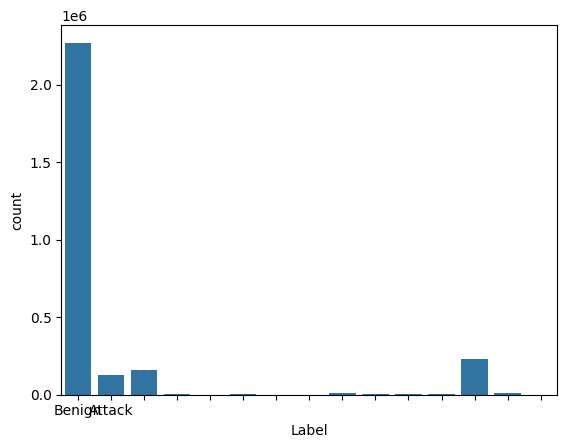

Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [29]:
# Plot the countplot for the 'Label' column
sns.countplot(x='Label', data=df_data)

# Change the x-tick labels to 'Benign' for 0 and 'Attack' for 1 only in the plot
plt.gca().set_xticklabels(['Benign', 'Attack'])

# Show the plot
plt.show()

# Print the original value counts (which retains 0 and 1)
print(df_data['Label'].value_counts())

## Label Encoding. 
## In this process, each unique category value is assigned a numerical label. This is often used for converting categorical data into a format that can be provided to machine learning algorithms.

## Mapping Labels to Numerical Values
### To prepare our dataset for machine learning, we converted the textual labels in our Label column into numerical values, mapping all types of attacks to 1 and benign traffic to 0. This binary classification approach simplifies our model's task to merely distinguishing between normal and malicious traffic,

In [30]:
df_data['Label'] = df_data['Label'].map({
    'BENIGN': 0,
    'DDoS': 1,
    'PortScan': 1,
    'Bot': 1,
    'Infiltration': 1,
    'Web Attack @ Brute Force': 1,
    'Web Attack @ XSS': 1,
    'Brute Force': 1,
    'Web Attack @ SQL Injection': 1,
    'FTP-Patator': 1,
    'SSH-Patator': 1,
    'DoS slowloris': 1,
    'DoS Slowhttptest': 1,
    'DoS Hulk': 1,
    'DoS GoldenEye': 1,
    'Heartbleed': 1
})

## Distribution of Network Traffic Types in the Dataset
### Before performing undersampling method

/var/folders/83/s9_py62d54b6v0352dkn68_80000gp/T/ipykernel_11813/3274448374.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Benign', 'Attack'])


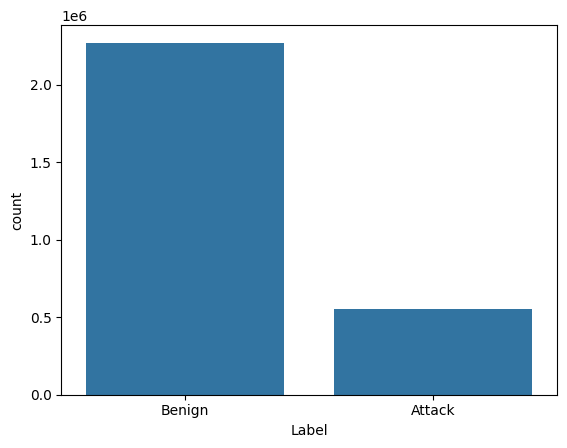

Label
0.0    2271320
1.0     554376
Name: count, dtype: int64


In [31]:
# Plot the countplot for the 'Label' column
sns.countplot(x='Label', data=df_data)

# Change the x-tick labels to 'Benign' for 0 and 'Attack' for 1 only in the plot
plt.gca().set_xticklabels(['Benign', 'Attack'])

# Show the plot
plt.show()

# Print the original value counts (which retains 0 and 1)
print(df_data['Label'].value_counts())

## Downsampling method

In [32]:
from sklearn.utils import resample

# Assuming df_data is your DataFrame after cleaning and encoding
df_majority = df_data[df_data['Label'] == 0]  # Benign
df_minority = df_data[df_data['Label'] == 1]  # Attack

# Downsample the majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority), # to match minority class
                                   random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the dataset to avoid any ordering bias
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

# Continue with further analysis or model training
print(df_balanced['Label'].value_counts())  # To verify balancing


Label
1.0    554376
0.0    554376
Name: count, dtype: int64


## After performing downsampling method

/var/folders/83/s9_py62d54b6v0352dkn68_80000gp/T/ipykernel_11813/1610300154.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Benign', 'Attack'])


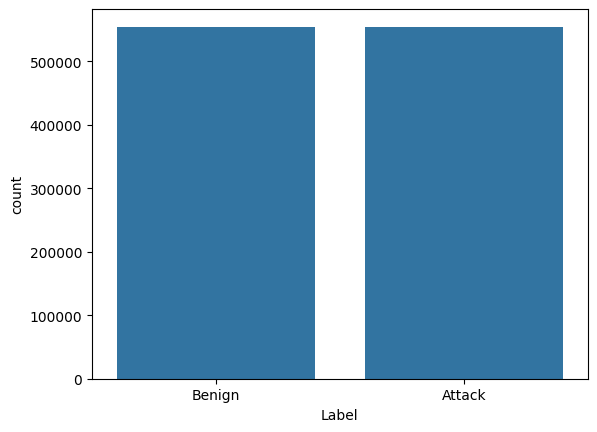

Label
1.0    554376
0.0    554376
Name: count, dtype: int64


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure to use df_balanced here
sns.countplot(x='Label', data=df_balanced)

# Change the x-tick labels to 'Benign' for 0 and 'Attack' for 1 only in the plot
plt.gca().set_xticklabels(['Benign', 'Attack'])

# Show the plot
plt.show()

# This will confirm the counts visually and numerically
print(df_balanced['Label'].value_counts())


## check for missing values

In [34]:
has_missing_values = df_balanced['Label'].isna().any()
print("Are there any missing values in 'Label' column?:", has_missing_values)

Are there any missing values in 'Label' column?: False


## drop missing values if any

In [35]:
# df_balanced = df_balanced.dropna(subset=['Label'])

### isna().sum(): Understanding how many missing values in 'Label' column
### unique(): Knowing the unique values in the 'Label' column 

In [36]:
print(df_balanced['Label'].isna().sum())
print(df_balanced['Label'].unique())

0
[1. 0.]


In [37]:
print(f"Number of duplicate rows: {df_balanced.duplicated().sum()}")
df_balanced = df_balanced.drop_duplicates()
print(f"Number of duplicate rows after removal: {df_balanced.duplicated().sum()}")

Number of duplicate rows: 155495
Number of duplicate rows after removal: 0


In [38]:
df_balanced['Label'].value_counts()

Label
0.0    529659
1.0    423598
Name: count, dtype: int64

## After removing duplicates, this shows a slight imbalance.
### Moderate Imbalance: The ratio between the two classes is about 1.25:1, which is a moderate imbalance.

/var/folders/83/s9_py62d54b6v0352dkn68_80000gp/T/ipykernel_11813/1610300154.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Benign', 'Attack'])


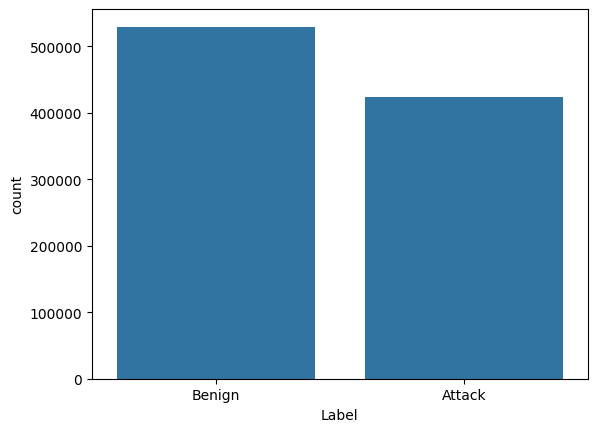

Label
0.0    529659
1.0    423598
Name: count, dtype: int64


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure to use df_balanced here
sns.countplot(x='Label', data=df_balanced)

# Change the x-tick labels to 'Benign' for 0 and 'Attack' for 1 only in the plot
plt.gca().set_xticklabels(['Benign', 'Attack'])

# Show the plot
plt.show()

# This will confirm the counts visually and numerically
print(df_balanced['Label'].value_counts())


## Create a heatmap to visualize missing values

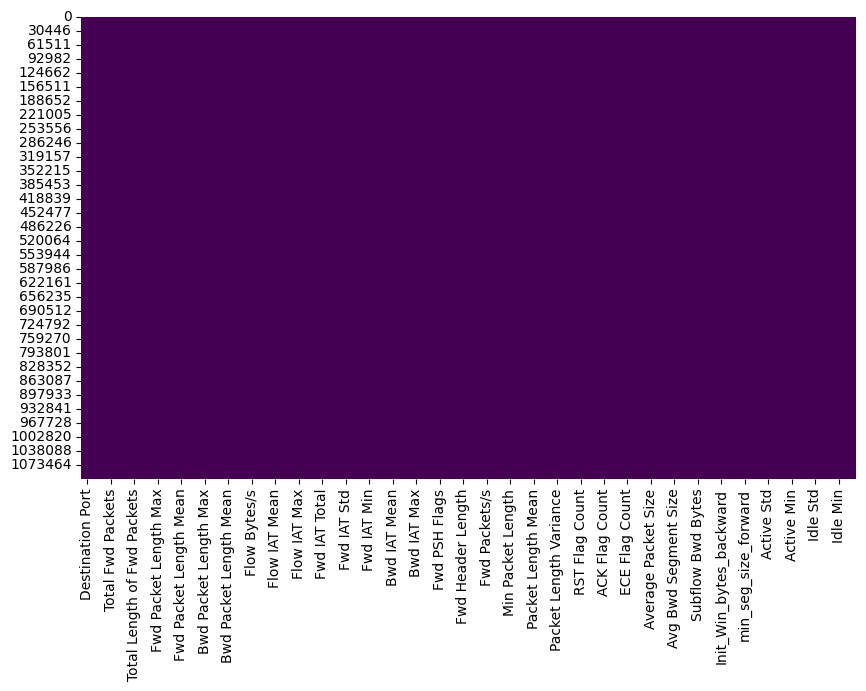

In [40]:
plt.figure(figsize=(10,6))
sns.heatmap(df_balanced.isnull(), cbar=False, cmap='viridis')
plt.show()

### Color: The uniform color (purple in this case) across the entire heatmap indicates consistency in the data regarding the presence or absence of missing values. Since the heatmap shows no variation in color, it tells us that there are no missing (NaN) values in any part of your DataFrame.
### Vertical Axis: Since our DataFrame likely contains a large number of rows, only some index labels are shown
### Horizontal Axis (X-axis): Displays the feature or column names of your DataFrame. All columns are represented, and the uniformity of color across all columns confirms that no columns contain missing data.

## Quantitative check to confirm that there are indeed no missing values in the dataset

In [41]:
total_missing = df_balanced.isnull().sum().sum()
print("Total missing values in the dataset:", total_missing)


Total missing values in the dataset: 0


## Identifying Categorical Features Based on Unique Value Counts

In [42]:
categorical_columns = []

for c in df_balanced.columns:
    # Check if the column is categorical (dtype of object or category) or numerical with less than 10 unique values
    if df_balanced[c].nunique() < 10:
        # Print unique values of columns with < 10 unique values
        print(f"Column '{c}' has unique values: {df_balanced[c].unique()}")
        categorical_columns.append(c)

# If you want to display the list of categorical columns with unique values < 10
print("Columns with unique values < 10:")
print(categorical_columns)

Column 'Fwd PSH Flags' has unique values: [0 1]
Column 'Fwd URG Flags' has unique values: [0 1]
Column 'FIN Flag Count' has unique values: [0 1]
Column 'RST Flag Count' has unique values: [0 1]
Column 'PSH Flag Count' has unique values: [1 0]
Column 'ACK Flag Count' has unique values: [0 1]
Column 'URG Flag Count' has unique values: [0 1]
Column 'ECE Flag Count' has unique values: [0 1]
Column 'Label' has unique values: [1. 0.]
Columns with unique values < 10:
['Fwd PSH Flags', 'Fwd URG Flags', 'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'ECE Flag Count', 'Label']


## Create numerical columns list and remove the target from categorical columns

In [43]:
numerical_columns = [col for col in df_balanced.columns if col not in categorical_columns]
categorical_columns.remove('Label')

In [44]:
categorical_columns

['Fwd PSH Flags',
 'Fwd URG Flags',
 'FIN Flag Count',
 'RST Flag Count',
 'PSH Flag Count',
 'ACK Flag Count',
 'URG Flag Count',
 'ECE Flag Count']

In [45]:
df_balanced[categorical_columns].dtypes

Fwd PSH Flags     int64
Fwd URG Flags     int64
FIN Flag Count    int64
RST Flag Count    int64
PSH Flag Count    int64
ACK Flag Count    int64
URG Flag Count    int64
ECE Flag Count    int64
dtype: object

## Exploratory Data Analysis (EDA) 

## Class Distribution
### Check the distribution of the target variable (Label) to identify whether the data is balanced or imbalanced.

## Before balancing

/var/folders/83/s9_py62d54b6v0352dkn68_80000gp/T/ipykernel_11813/3274448374.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Benign', 'Attack'])


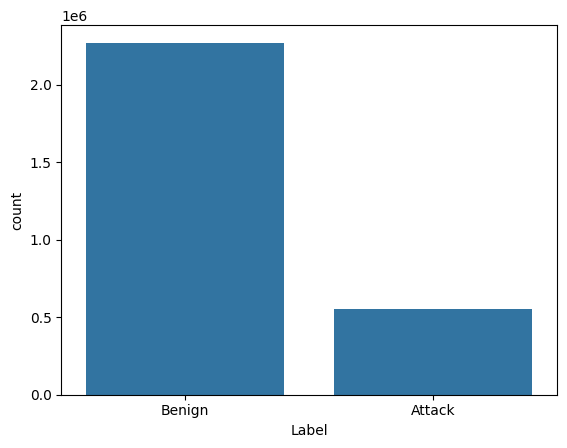

Label
0.0    2271320
1.0     554376
Name: count, dtype: int64


In [46]:
# Plot the countplot for the 'Label' column
sns.countplot(x='Label', data=df_data)

# Change the x-tick labels to 'Benign' for 0 and 'Attack' for 1 only in the plot
plt.gca().set_xticklabels(['Benign', 'Attack'])

# Show the plot
plt.show()

# Print the original value counts (which retains 0 and 1)
print(df_data['Label'].value_counts())

## after balancing the dataset

/var/folders/83/s9_py62d54b6v0352dkn68_80000gp/T/ipykernel_11813/963620443.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Benign', 'Attack'])


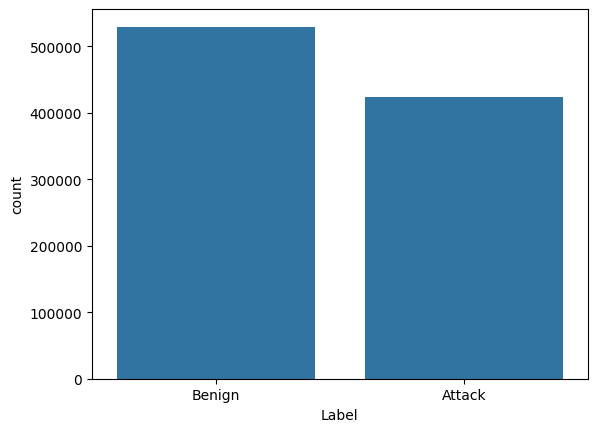

Label
0.0    2271320
1.0     554376
Name: count, dtype: int64


In [47]:
# Plot the countplot for the 'Label' column
sns.countplot(x='Label', data=df_balanced)

# Change the x-tick labels to 'Benign' for 0 and 'Attack' for 1 only in the plot
plt.gca().set_xticklabels(['Benign', 'Attack'])

# Show the plot
plt.show()

# Print the original value counts (which retains 0 and 1)
print(df_data['Label'].value_counts())

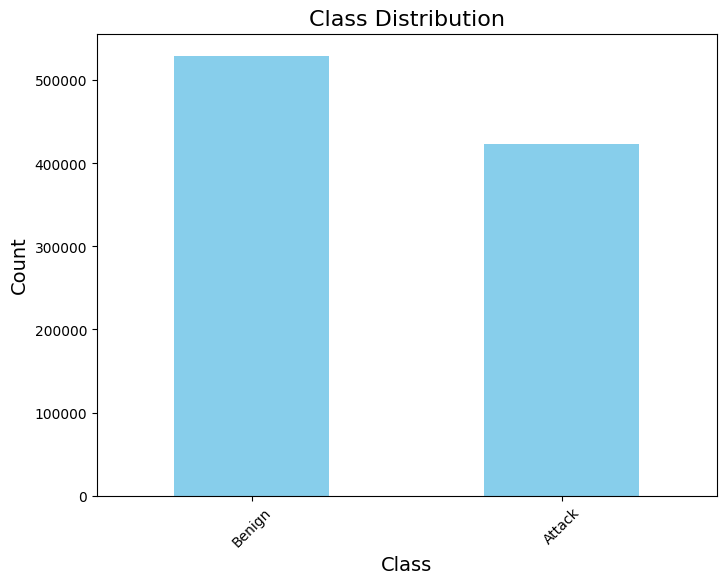

In [48]:
class_counts = df_balanced['Label'].value_counts()

plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')

plt.title('Class Distribution', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.gca().set_xticklabels(['Benign', 'Attack'])


plt.xticks(rotation=45)
plt.show()

### In our exploratory data analysis, we identified that our dataset is significantly imbalanced, with a larger number of 'Benign' instances compared to 'Attack'. This imbalance can lead to biased predictive models that perform well on the majority class but poorly on the minority class.

## Correlation Matrix
### Blue represents negative correlations, red represents positive correlations, and white or pale colors represent no correlation.

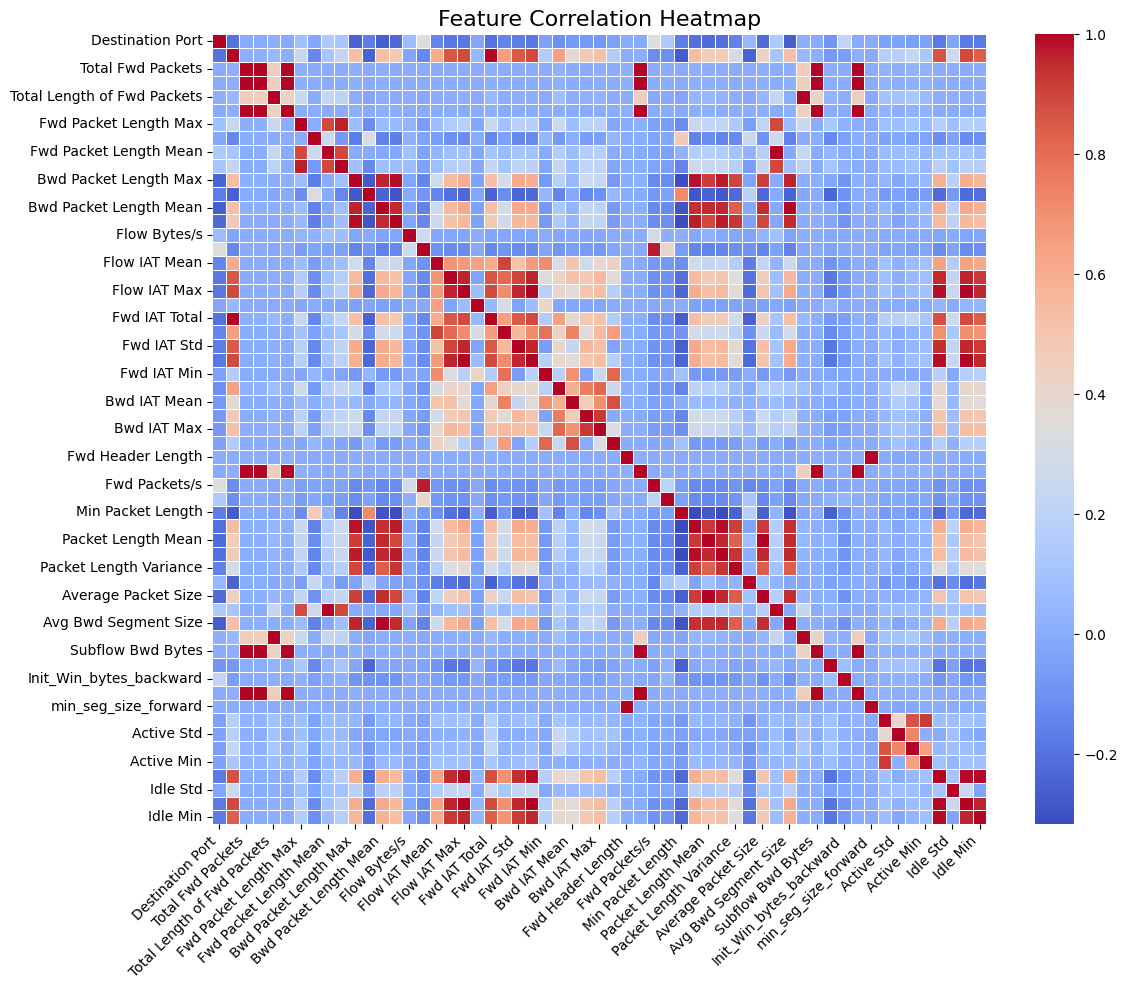

In [49]:
# Calculate the correlation matrix
corr_matrix = df_balanced[numerical_columns].corr()

# Plotting the heatmap with adjustments
plt.figure(figsize=(12, 10)) 
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()


## Since there are too many features, I focused on the most correlated features by selecting a subset

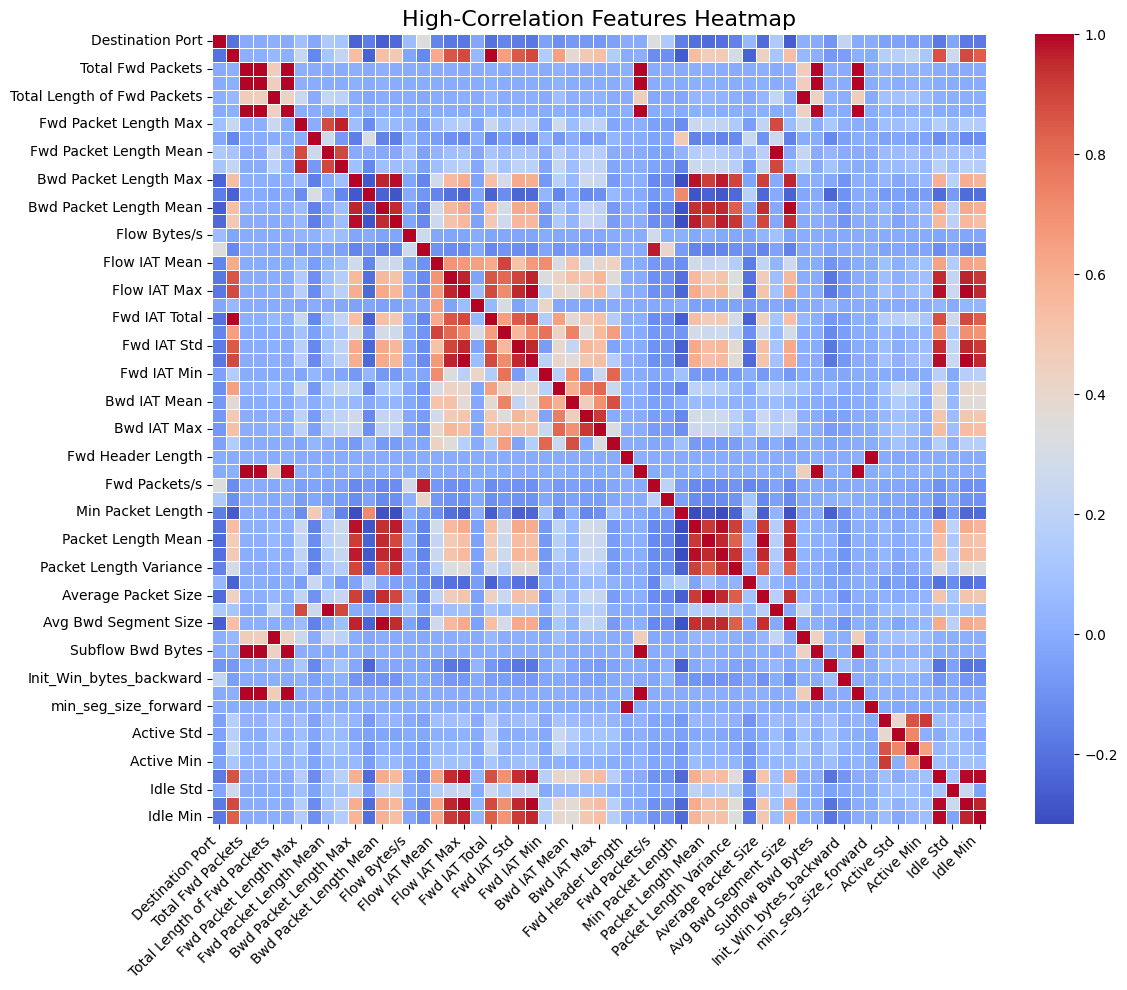

In [50]:
# Select top correlated features (optional)
corr_threshold = 0.5  # Example: Use a threshold to filter features
high_corr_features = corr_matrix.columns[(corr_matrix.abs() > corr_threshold).any()].tolist()

# Plot only the high-correlation features
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.loc[high_corr_features, high_corr_features], annot=False, cmap='coolwarm', linewidths=0.5)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('High-Correlation Features Heatmap', fontsize=16)
plt.tight_layout()
plt.show()


###  This particular heatmap visualizes the relationships among various network traffic features, which are crucial for identifying patterns that might suggest normal or malicious behaviors in network traffic data.

## Tabular summary of the most and least correlated features from a correlation matrix

In [51]:
def summarize_correlations(corr_matrix, n=5):
    # Create a DataFrame from the lower triangle of the correlation matrix, excluding the diagonal
    corr_df = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))
    
    # Stack the DataFrame and reset the index to turn it into a long format
    long_corr = corr_df.stack().reset_index()
    long_corr.columns = ['Feature1', 'Feature2', 'Correlation']

    # Get the top n most correlated features
    top_correlations = long_corr.nlargest(n, 'Correlation')
    
    # Get the top n least correlated features
    least_correlations = long_corr.nsmallest(n, 'Correlation')

    return top_correlations, least_correlations

# Get the summaries
top_correlations, least_correlations = summarize_correlations(corr_matrix, n=5)

# Print or return these summaries as needed
print("Top Correlations:")
print(top_correlations)
print("\nLeast Correlations:")
print(least_correlations)


Top Correlations:
                  Feature1                     Feature2  Correlation
828   Avg Fwd Segment Size       Fwd Packet Length Mean      1.00000
907      Subflow Fwd Bytes  Total Length of Fwd Packets      1.00000
873   Avg Bwd Segment Size       Bwd Packet Length Mean      1.00000
951      Subflow Bwd Bytes  Total Length of Bwd Packets      1.00000
1158  min_seg_size_forward            Fwd Header Length      0.99994

Least Correlations:
                 Feature1               Feature2  Correlation
629     Max Packet Length      Min Packet Length    -0.316414
700     Packet Length Std      Min Packet Length    -0.315996
571     Min Packet Length  Bwd Packet Length Max    -0.310818
574     Min Packet Length  Bwd Packet Length Std    -0.309956
895  Avg Bwd Segment Size      Min Packet Length    -0.291619


## Distribution of Features
### Plot the distribution of key numerical features to understand their behavior in both normal and attack classes.

In [52]:
feature_list = df_balanced.columns.tolist()
print(feature_list)

['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Av

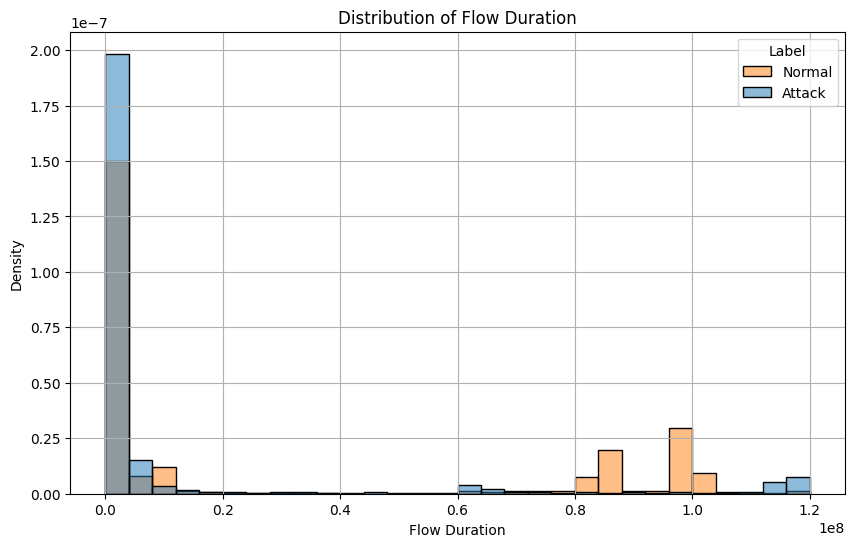

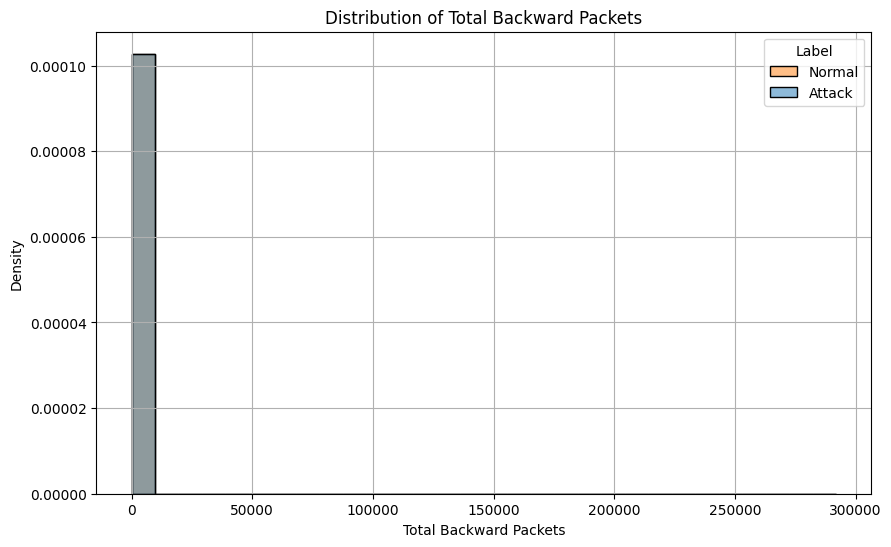

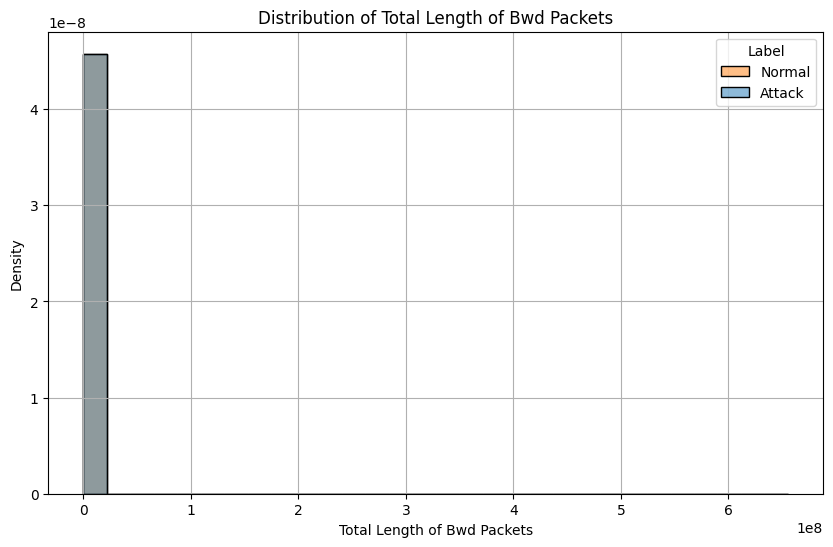

In [53]:
features_to_plot = ['Flow Duration', 'Total Backward Packets', 'Total Length of Bwd Packets']

for feature in features_to_plot:
    plt.figure(figsize=(10, 6))  
    # Creating a histogram with the seaborn library, adding hue for labels, and reducing bins for clarity
    sns.histplot(data=df_data, x=feature, hue='Label', kde=False, bins=30, stat="density", common_norm=False)
    plt.xlabel(feature)  # Add an X-axis label with the name of the feature
    plt.ylabel('Density')  # Add a Y-axis label 'Density'
    plt.title(f'Distribution of {feature}')  # Setting the title to reflect the feature being plotted
    plt.legend(title='Label', labels=['Normal', 'Attack'])  # Ensure the legend is correctly labeled
    plt.grid(True)  # Enable grid for easier analysis of scales and values
    plt.show()  # Display the plot


## Box Plot to Check Outliers
### Box plots help identify outliers within the dataset for each feature. Box plots for each numerical column


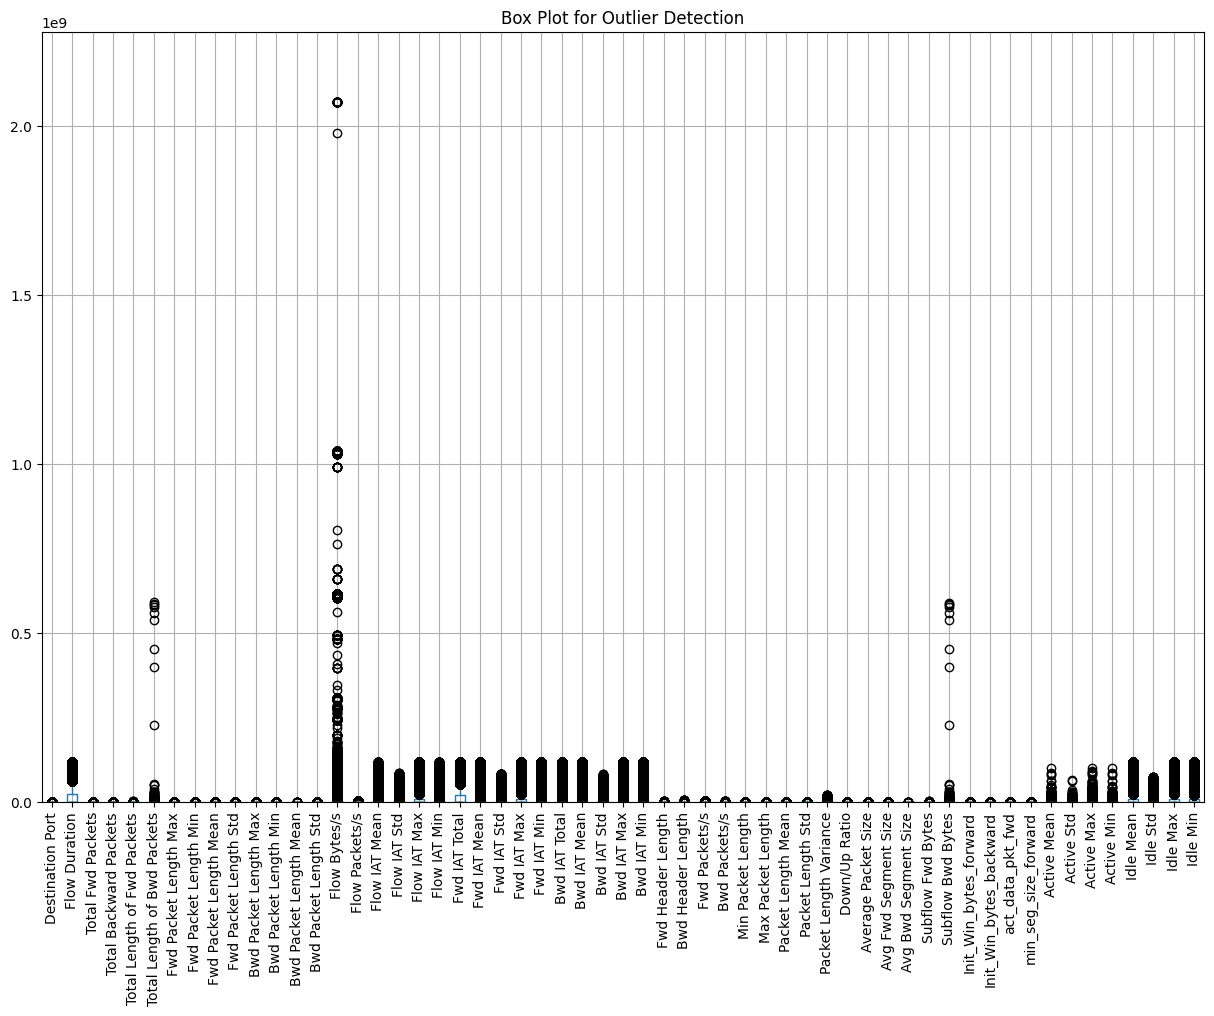

In [54]:
plt.figure(figsize=(15, 10))
df_balanced[numerical_columns].boxplot(rot=90)
plt.title("Box Plot for Outlier Detection")
plt.ylim(0, max(df_balanced[numerical_columns].max())*1.1)
plt.show()

## Outlier using balanced dataset

### Focus on the "Flow Bytes/s" column only

(0.0, 2278100000.0)

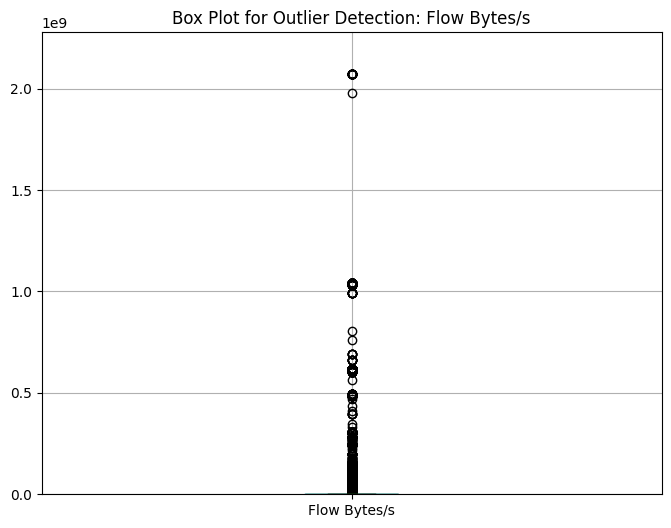

In [55]:
column_of_interest = 'Flow Bytes/s'

# Plot box plot for the selected column
plt.figure(figsize=(8, 6))
df_balanced[[column_of_interest]].boxplot()
plt.title(f"Box Plot for Outlier Detection: {column_of_interest}")
plt.ylim(0, df_balanced[column_of_interest].max() * 1.1) 


## Outlier using imbalanced dataset

(0.0, 2278100000.0)

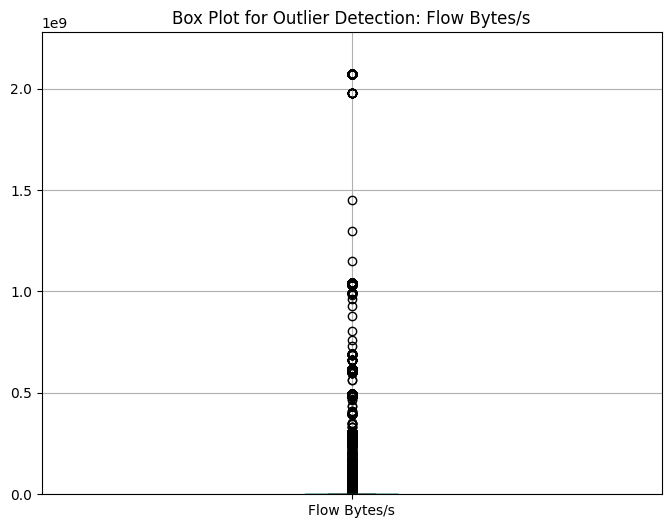

In [56]:
column_of_interest = 'Flow Bytes/s'

# Plot box plot for the selected column
plt.figure(figsize=(8, 6))
df_data[[column_of_interest]].boxplot()
plt.title(f"Box Plot for Outlier Detection: {column_of_interest}")
plt.ylim(0, df_data[column_of_interest].max() * 1.1) 


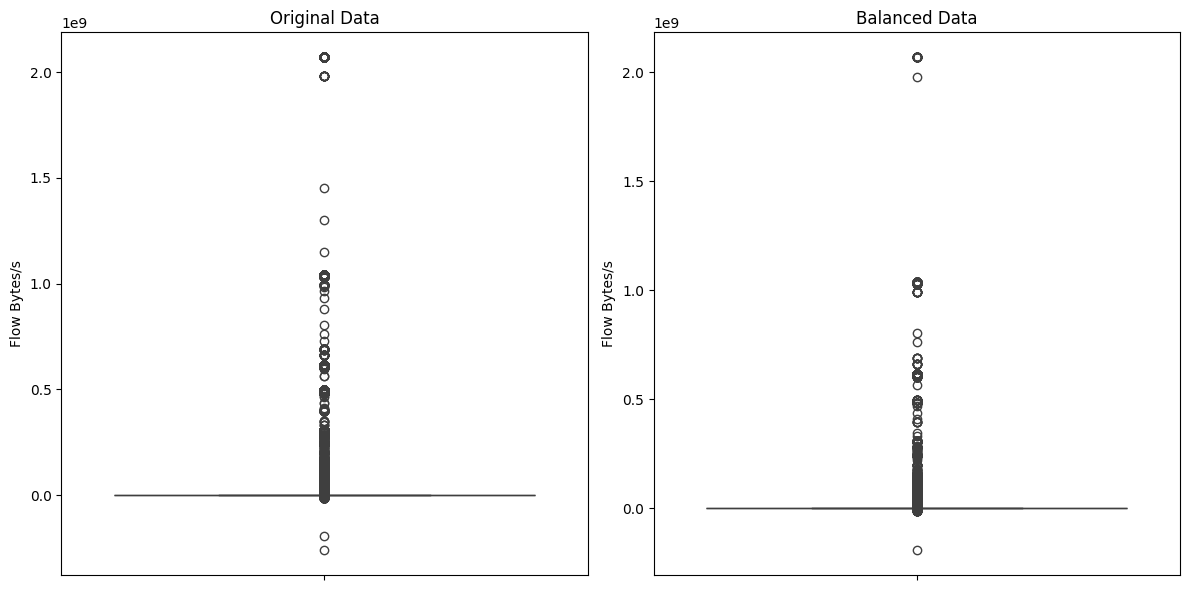

In [57]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df_data['Flow Bytes/s'])
plt.title('Original Data')
plt.subplot(1, 2, 2)
sns.boxplot(y=df_balanced['Flow Bytes/s'])
plt.title('Balanced Data')
plt.tight_layout()
plt.show()


### Balancing the dataset has made some improvements in terms of reducing the number and extremity of outliers,

## Feature Engineering

### Feature Importance

In [58]:
# Drop rows with missing values
X = df_balanced.drop('Label',axis=1)

# Make sure to drop corresponding rows in y
y = df_balanced['Label']

# Split the dataset into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

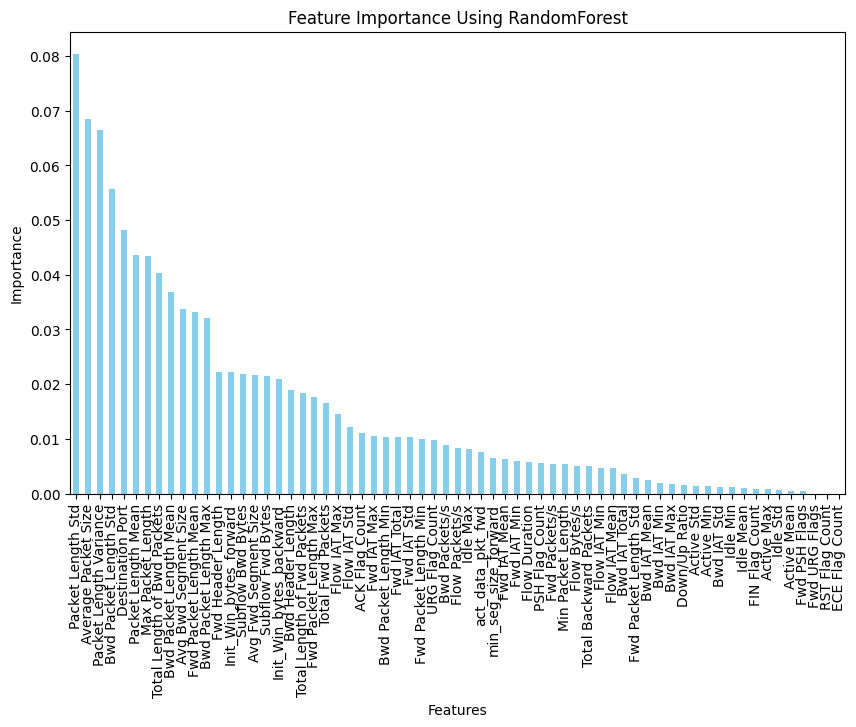

In [59]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Train the RandomForestClassifier
rf.fit(X_train, y_train)

# Calculate feature importances
feature_importances = rf.feature_importances_

# Convert to a pandas DataFrame for easier visualization
importance_series = pd.Series(feature_importances, index=X_train.columns)

# Sort the features by importance
importance_series = importance_series.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
importance_series.plot(kind='bar', color='skyblue')
plt.title('Feature Importance Using RandomForest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

## calculate the importance for every feature

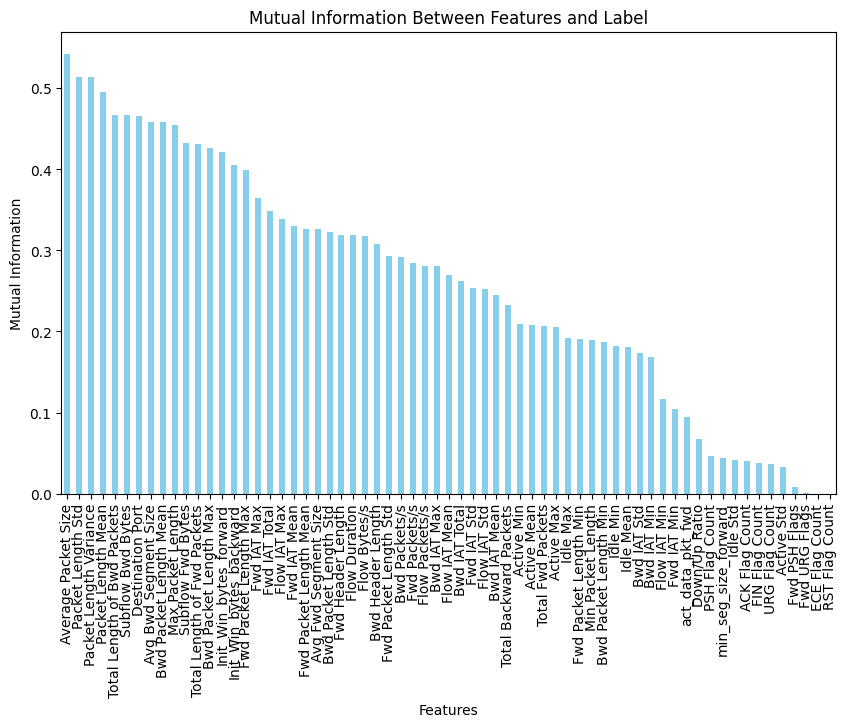

In [60]:
# # Assuming 'Label' is your target variable and the rest are features
X = df_balanced.drop('Label', axis=1)  # Features
y = df_balanced['Label']  # Target


# # Split the dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Calculate mutual information between numerical features and the target
importances = mutual_info_classif(X_train, y_train)

# Convert to a pandas DataFrame for easier visualization
mi_series = pd.Series(importances, index=X.columns)

# Sort the features by importance
mi_series = mi_series.sort_values(ascending=False)

# Plot the mutual information values
plt.figure(figsize=(10, 6))
mi_series.plot(kind='bar', color='skyblue')
plt.title('Mutual Information Between Features and Label')
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.show()

## calculate the sum of importance scores

In [61]:
# Sort the feature importances along with the feature names (numerical_columns)
f_list = sorted(zip(map(lambda x: round(x, 4), importances), X_train.columns), reverse=True) ## 

# Initialize variables
Sum = 0
fs = []

# Calculate the sum of feature importances and store features
for i in range(len(f_list)):
    Sum += f_list[i][0]  # Summing up the importance scores
    fs.append(f_list[i][1])  # Append the feature name to the list

# Optional: Print or return the feature importances and the sum
print("Sum of feature importances:", Sum)

Sum of feature importances: 16.8837


## We select the important feature until the accumulated importance reaches 90%

In [62]:
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), X_train.columns), reverse=True)
Sum2 = 0
fs = []

for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    
    if Sum2 >= 0.9:
        break

In [63]:
print(len(fs))
print(fs)
feature_selected = ['Average Packet Size', 'Packet Length Variance', 'Packet Length Std', 'Packet Length Mean', 'Total Length of Bwd Packets', 'Subflow Bwd Bytes', 'Destination Port', 'Bwd Packet Length Mean', 'Avg Bwd Segment Size', 'Max Packet Length', 'Subflow Fwd Bytes', 'Total Length of Fwd Packets', 'Bwd Packet Length Max', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'Fwd Packet Length Max', 'Fwd IAT Max', 'Fwd IAT Total', 'Flow IAT Max', 'Fwd IAT Mean', 'Fwd Packet Length Mean', 'Avg Fwd Segment Size', 'Bwd Packet Length Std', 'Fwd Header Length', 'Flow Duration', 'Flow Bytes/s', 'Bwd Header Length', 'Fwd Packet Length Std', 'Bwd Packets/s', 'Fwd Packets/s', 'Flow Packets/s', 'Bwd IAT Max', 'Flow IAT Mean', 'Bwd IAT Total', 'Fwd IAT Std', 'Flow IAT Std', 'Bwd IAT Mean', 'Total Backward Packets', 'Active Min', 'Active Mean', 'Total Fwd Packets', 'Active Max', 'Idle Max', 'Fwd Packet Length Min', 'Min Packet Length']

45
['Average Packet Size', 'Packet Length Variance', 'Packet Length Std', 'Packet Length Mean', 'Total Length of Bwd Packets', 'Subflow Bwd Bytes', 'Destination Port', 'Avg Bwd Segment Size', 'Bwd Packet Length Mean', 'Max Packet Length', 'Total Length of Fwd Packets', 'Subflow Fwd Bytes', 'Bwd Packet Length Max', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'Fwd Packet Length Max', 'Fwd IAT Max', 'Fwd IAT Total', 'Flow IAT Max', 'Fwd IAT Mean', 'Fwd Packet Length Mean', 'Avg Fwd Segment Size', 'Bwd Packet Length Std', 'Fwd Header Length', 'Flow Duration', 'Flow Bytes/s', 'Bwd Header Length', 'Fwd Packet Length Std', 'Bwd Packets/s', 'Fwd Packets/s', 'Flow Packets/s', 'Bwd IAT Max', 'Flow IAT Mean', 'Bwd IAT Total', 'Fwd IAT Std', 'Flow IAT Std', 'Bwd IAT Mean', 'Total Backward Packets', 'Active Min', 'Active Mean', 'Total Fwd Packets', 'Active Max', 'Idle Max', 'Fwd Packet Length Min', 'Min Packet Length']


### Splitting of the data
#### HoldOut Validation Approach Train and test split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

###  It means whenever we use 42 as random_state, it’ll return a shuffled dataset.

### Apply Z-Score Normalization

### In our preprocessing steps, we applied Z-score normalization to our numerical features using StandardScaler. This method standardizes the features so that each has a mean of zero and a standard deviation of one, aligning with the Z-score formula.

In [65]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler only on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train[numerical_columns])

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test[numerical_columns])

In [66]:
X_train_scaled

array([[-3.85055550e-01, -5.91344282e-01, -1.12249973e-02, ...,
        -1.50762618e-01, -5.29175115e-01, -5.00670784e-01],
       [-3.83388322e-01, -3.04084415e-01,  1.73399351e-03, ...,
        -1.50762618e-01, -3.45199102e-01, -3.10919717e-01],
       [-3.85055550e-01, -5.92288837e-01, -1.12249973e-02, ...,
        -1.50762618e-01, -5.29175115e-01, -5.00670784e-01],
       ...,
       [-3.83388322e-01, -5.41596412e-01, -6.90533369e-03, ...,
        -1.50762618e-01, -5.29175115e-01, -5.00670784e-01],
       [-3.60973365e-01, -5.83457512e-01, -4.74550189e-03, ...,
        -1.50762618e-01, -5.29175115e-01, -5.00670784e-01],
       [-3.83388322e-01,  1.49988813e+00, -4.25838289e-04, ...,
        -1.50762618e-01,  1.82702832e+00,  1.92949447e+00]])

### This code handles the integration of scaled numerical data with unscaled categorical data

In [67]:
# Convert the scaled data back into DataFrames for ease of use
# columns=numerical_columns: This specifies the column names for the new DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_columns)

# axis=1 means along "columns". It's a column-wise operation.
X_train_final = pd.concat([X_train_scaled_df, X_train[categorical_columns].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test[categorical_columns].reset_index(drop=True)], axis=1)

# Print the shape of the final datasets to verify the concatenation
print("X_train_final shape:", X_train_final.shape)
print("X_test_final shape:", X_test_final.shape)

X_train_final shape: (571954, 65)
X_test_final shape: (381303, 65)


## This cell represent how data are represented before being scaled

In [68]:
X_train_final.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Bytes,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Fwd PSH Flags,Fwd URG Flags,FIN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,ECE Flag Count
0,-0.385056,-0.591344,-0.011225,-0.008794,-0.056855,-0.007622,-0.261910,0.443914,-0.099492,-0.286997,-0.606321,1.113431,-0.583223,-0.599307,-0.047048,-0.217414,-0.412879,-0.534120,-0.542073,-0.059760,-0.584846,-0.413916,-0.513209,-0.538616,-0.113372,-0.367396,-0.238057,-0.285975,-0.312806,-0.108452,0.001231,-0.010040,-0.190360,-0.182073,1.080457,-0.622205,-0.588838,-0.618065,-0.479961,0.493211,-0.573993,-0.099492,-0.583223,-0.056855,-0.007622,-0.524722,-0.208353,-0.007178,0.001377,-0.146733,-0.100123,-0.160652,-0.124642,-0.520116,-0.150763,-0.529175,-0.500671,0,0,0,0,0,0,0,0
1,-0.383388,-0.304084,0.001734,-0.005543,0.015035,0.000671,0.613384,-0.264725,0.128856,0.556765,3.341728,-0.480231,2.570608,3.905689,-0.047210,-0.217782,-0.218954,-0.320089,-0.359351,-0.059747,-0.421496,-0.324468,-0.343553,-0.354481,-0.113347,0.016713,0.189123,0.086886,-0.027182,-0.108332,0.001382,-0.004192,-0.190557,-0.182905,-0.525599,3.297158,1.467963,2.803913,3.524183,-1.043032,1.437243,0.128856,2.570608,0.015035,0.000671,1.642011,-0.176001,-0.007178,0.001377,-0.145344,-0.100123,-0.159675,-0.123126,-0.331376,-0.150763,-0.345199,-0.310920,0,0,0,0,1,0,0,0
2,-0.385056,-0.592289,-0.011225,-0.008794,-0.057136,-0.007572,-0.263507,0.424230,-0.105663,-0.286997,-0.594683,1.666335,-0.545063,-0.599307,-0.046575,-0.216822,-0.415251,-0.536129,-0.543141,-0.059760,-0.584846,-0.413916,-0.513209,-0.538616,-0.113372,-0.367396,-0.238057,-0.285975,-0.312806,-0.108453,0.001213,-0.010040,-0.190043,-0.180744,1.035844,-0.610651,-0.558416,-0.597454,-0.479312,0.493211,-0.539298,-0.105663,-0.545063,-0.057136,-0.007573,-0.524722,-0.208353,-0.007178,0.001269,-0.146733,-0.100123,-0.160652,-0.124642,-0.520116,-0.150763,-0.529175,-0.500671,0,0,0,0,0,0,0,0
3,2.724881,-0.592886,-0.013385,-0.010419,-0.066123,-0.007760,-0.309827,-0.146619,-0.284638,-0.286997,-0.637812,-0.382659,-0.686481,-0.599307,-0.023753,0.241973,-0.416746,-0.537400,-0.543815,-0.059754,-0.584846,-0.413916,-0.513209,-0.538616,-0.113373,-0.367396,-0.238057,-0.285975,-0.312807,-0.108453,0.001198,-0.013614,0.056472,0.850192,-0.257923,-0.653467,-0.717082,-0.654576,-0.480409,0.493211,-0.717043,-0.284638,-0.686481,-0.066123,-0.007760,-0.499791,-0.172998,-0.009434,0.001269,-0.146733,-0.100123,-0.160652,-0.124642,-0.520116,-0.150763,-0.529175,-0.500671,0,0,0,0,0,1,1,0
4,-0.360973,-0.566153,-0.011225,-0.012045,-0.065280,-0.007764,-0.309827,-0.146619,-0.284638,-0.286997,-0.639866,-0.480231,-0.693215,-0.599307,-0.047261,-0.217777,-0.215346,-0.537400,-0.513601,0.242355,-0.558112,-0.311444,-0.513209,-0.508472,0.011720,-0.367396,-0.238057,-0.285975,-0.312807,-0.108453,0.001213,-0.015238,-0.190550,-0.182914,-0.257923,-0.653467,-0.717082,-0.654576,-0.480409,-1.043032,-0.717043,-0.284638,-0.693215,-0.065280,-0.007764,-0.505653,-0.208353,-0.007178,0.001269,-0.146733,-0.100123,-0.160652,-0.124642,-0.520116,-0.150763,-0.529175,-0.500671,0,0,0,0,0,1,0,0


## This cell represent how dataframe are represented after being scaled

In [69]:
df_balanced.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Bytes,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,5950,70,1,1,2,6,2,2,2.000000,0.000000,6,6,6.000000,0.000000,114285.714300,28571.428570,70.00000,0.00000,70,70,0,0.0,0.000000,0,0,0,0.0,0.00000,0,0,0,0,24,20,14285.714290,14285.714290,2,6,3.333333,2.309401,5.333333e+00,0,0,1,0,0,0,1,5.000000,2.000000,6.000000,2,6,1024,0,0,24,0.0,0.0,0,0,0.0,0.0,0,0,1.0
1,80,149593,3,7,304,11595,304,0,101.333333,175.514482,4344,0,1656.428571,1547.737688,79542.491960,66.848048,16621.44444,45389.56773,137208,3,11998,5999.0,8479.624520,11995,3,149517,24919.5,55213.69514,137208,30,0,0,104,232,20.054414,46.793633,0,4344,1081.727273,1442.226896,2.080018e+06,0,0,1,0,0,0,2,1189.900000,101.333333,1656.428571,304,11595,29200,235,1,32,0.0,0.0,0,0,0.0,0.0,0,0,1.0
2,80,1251034,3,6,26,11607,20,0,8.666667,10.263203,5840,0,1934.500000,2538.919278,9298.708109,7.194049,156379.25000,441388.47390,1248759,31,1910,955.0,1204.909955,1807,103,1251003,250200.6,558211.69860,1248759,46,0,0,72,132,2.398016,4.796033,0,5840,1163.300000,2138.329153,4.572452e+06,0,0,1,0,0,0,2,1292.555556,8.666667,1934.500000,26,11607,8192,229,2,20,0.0,0.0,0,0,0.0,0.0,0,0,1.0
3,7512,64,1,1,2,6,2,2,2.000000,0.000000,6,6,6.000000,0.000000,125000.000000,31250.000000,64.00000,0.00000,64,64,0,0.0,0.000000,0,0,0,0.0,0.00000,0,0,0,0,24,20,15625.000000,15625.000000,2,6,3.333333,2.309401,5.333333e+00,0,0,1,0,0,0,1,5.000000,2.000000,6.000000,2,6,1024,0,0,24,0.0,0.0,0,0,0.0,0.0,0,0,1.0
4,1064,63,1,1,2,6,2,2,2.000000,0.000000,6,6,6.000000,0.000000,126984.127000,31746.031750,63.00000,0.00000,63,63,0,0.0,0.000000,0,0,0,0.0,0.00000,0,0,0,0,24,20,15873.015870,15873.015870,2,6,3.333333,2.309401,5.333333e+00,0,0,1,0,0,0,1,5.000000,2.000000,6.000000,2,6,1024,0,0,24,0.0,0.0,0,0,0.0,0.0,0,0,1.0


# Training Models on all the features
#### Model that could be use for binary classification

In [70]:
score = []  # For normal training results
score_hyper = []  # For hyperparameter tuning results

In [71]:
def save_best_params_to_json(model_name, best_params):
    filename= "best_params_multiple_models.json"
    # Check if the file already exists
    if os.path.exists(filename):
        # Load existing data
        with open(filename, 'r') as file:
            data = json.load(file)
    else:
        # Create a new dictionary if the file does not exist
        data = {}

    # Update the dictionary with the new model's best parameters
    data[model_name] = best_params

    # Write updated dictionary back to the JSON file
    with open(filename, 'w') as file:
        json.dump(data, file, indent=4)

In [72]:
def save_best_fs_params_to_json(model_name, best_params):
    filename= "best_params_fs_multiple_models.json"
    # Check if the file already exists
    if os.path.exists(filename):
        # Load existing data
        with open(filename, 'r') as file:
            data = json.load(file)
    else:
        # Create a new dictionary if the file does not exist
        data = {}

    # Update the dictionary with the new model's best parameters
    data[model_name] = best_params

    # Write updated dictionary back to the JSON file
    with open(filename, 'w') as file:
        json.dump(data, file, indent=4)

In [73]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix

def evaluate_model(y_test, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'f1 Score': f1_score(y_test, y_pred, average='weighted'),
        'mcc': matthews_corrcoef(y_test, y_pred)
    }
    return metrics

## SVM

In [ ]:
# from sklearn.svm import SVC

# # Initialize the SVM classifier
# svm = SVC(random_state=42)

# # Fit the SVM model on the training data
# svm.fit(X_train_final, y_train)

## 1. Random Forest Classifier

### Training 

In [74]:
rfc = RandomForestClassifier(random_state=42)
mlflow.set_experiment("training_by_default")
with mlflow.start_run(run_name="rfc_model"):
    # Fit the RandomForest model on the training data
    rfc.fit(X_train_final, y_train)

## K-Fold  Cross Validation

In [75]:
from sklearn.model_selection import  cross_validate

# Define K-Fold cross-validator
kfold_validation = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the classifier
rf_cross_scores = RandomForestClassifier(random_state=42)

# Perform k-fold cross-validation with multiple scoring metrics
rf_cross_scores = cross_validate(rf_cross_scores, X, y, cv=kfold_validation, scoring='accuracy', return_train_score=True)

# Print the scores for each fold and metric
print("Average Accuracy Score:", rf_cross_scores['test_score'].mean())
print(rf_cross_scores)

Average Accuracy Score: 0.9986677255807346
{'fit_time': array([118.86544013, 121.31006384, 122.88165283, 115.60968781,
       116.755059  ]), 'score_time': array([0.74010992, 0.74917817, 0.75271201, 0.85770798, 0.74875689]), 'test_score': array([0.99853136, 0.99872018, 0.99876214, 0.99865723, 0.99866772]), 'train_score': array([0.9998374 , 0.99982429, 0.99983084, 0.99983215, 0.99984527])}


In [76]:
rf_cross_scores

{'fit_time': array([118.86544013, 121.31006384, 122.88165283, 115.60968781,
        116.755059  ]),
 'score_time': array([0.74010992, 0.74917817, 0.75271201, 0.85770798, 0.74875689]),
 'test_score': array([0.99853136, 0.99872018, 0.99876214, 0.99865723, 0.99866772]),
 'train_score': array([0.9998374 , 0.99982429, 0.99983084, 0.99983215, 0.99984527])}

### Testing

In [77]:
# Make predictions on the test data
y_pred = rfc.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score.append(['Random Forest', accuracy, recall, precision, f1, mcc])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

Accuracy: 99.89142492978024
Recall: 99.89142492978024
Precision: 99.89142426783143
F1 Score: 99.89142442075556
MCC: 99.7801725592794


### Confusion matrix

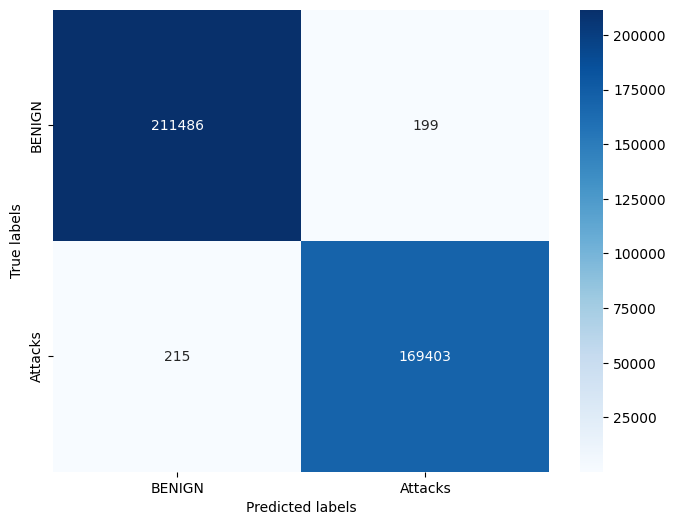

In [78]:
# Confusion matrix
cm_rfc = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rfc, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

### Let's proceed with RandomizedSearchCV
### Hyperparameter Tuning

In [81]:
import mlflow

# Set the MLflow tracking URI if it's not set
mlflow.set_tracking_uri("http://localhost:5001")

# Verify if the tracking URI is set correctly
print("Current MLflow Tracking URI: ", mlflow.get_tracking_uri())


Current MLflow Tracking URI:  http://localhost:5000


In [82]:
mlflow.set_tracking_uri("http://localhost:5001")  # replace with your tracking URI

# Define parameter grid
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=16,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
mlflow.set_experiment("hyperparameter_tuning")


# automatically starts and ends an MLflow run
with mlflow.start_run(run_name="random_forest_tuned"):
    # Fit the RandomForest model on the training data
    random_search.fit(X_train_final, y_train)

    # Save the best parameters
    model_name = "Random Forest"
    best_params = random_search.best_params_
    mlflow.log_params(best_params)

    # Optionally log the model as well
    mlflow.sklearn.log_model(random_search.best_estimator_, "random_forest_model_mlflow")


save_best_params_to_json(model_name, best_params)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  41.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  42.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  43.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  43.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  44.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  47.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END max_depth=10, min_samples_l

2024/09/22 19:42:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/22 19:42:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run random_forest_tuned at: http://localhost:5001/#/experiments/469953685001500752/runs/3d628e8cf58b4a4daed3c8bc6a9e4215.
2024/09/22 19:42:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/469953685001500752.


## Evaluation Steps

In [83]:
# Evaluate the best model on the test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_final)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper.append(['Random Forest (Tuned)', accuracy, recall, precision, f1, mcc])
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

Accuracy: 99.88880234354306
Recall: 99.88880234354306
Precision: 99.88880160893396
F1 Score: 99.88880143096654
MCC: 99.77486186901957


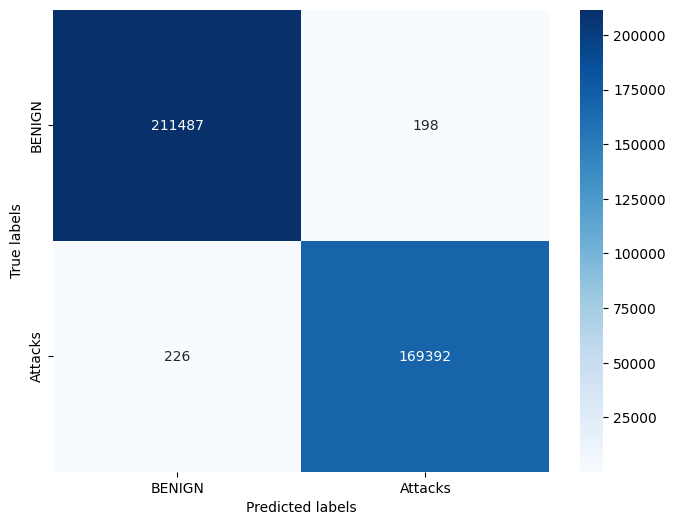

In [84]:
# Confusion matrix
cm_rfc_tuned = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rfc_tuned, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 2. XGB

### Training

In [85]:
# Initialize the XGBoost model
xgb = XGBClassifier(random_state=42)
mlflow.set_experiment("training_by_default")
with mlflow.start_run(run_name="xgb_model"):
    # Fit the RandomForest model on the training data
    xgb.fit(X_train_final, y_train)

2024/09/22 19:44:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run xgb_model at: http://localhost:5001/#/experiments/723724480696361092/runs/46239aa46b0c4a449d82ad1d550b934e.
2024/09/22 19:44:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/723724480696361092.


## K-fold Cross validation

In [86]:
from sklearn.model_selection import  cross_validate

# Define K-Fold cross-validator
kfold_validation = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the classifier
xgb_cross = XGBClassifier(random_state=42)

# Perform k-fold cross-validation with multiple scoring metrics
xgb_cross_scores = cross_validate(xgb_cross, X, y, cv=kfold_validation, scoring='accuracy', return_train_score=True)

# Print the scores for each fold and metric
print("Average Accuracy Score:", xgb_cross_scores['test_score'].mean())
print(xgb_cross_scores)

Average Accuracy Score: 0.9993076367216563
{'fit_time': array([2.79625511, 2.58950138, 2.40384912, 2.56700397, 2.90363908]), 'score_time': array([0.08075595, 0.07623672, 0.08773303, 0.09234595, 0.07072186]), 'test_score': array([0.99931288, 0.99944401, 0.99920273, 0.99933911, 0.99923945]), 'train_score': array([0.99945975, 0.99941123, 0.99944795, 0.99944008, 0.99945844])}


In [87]:
xgb_cross_scores

{'fit_time': array([2.79625511, 2.58950138, 2.40384912, 2.56700397, 2.90363908]),
 'score_time': array([0.08075595, 0.07623672, 0.08773303, 0.09234595, 0.07072186]),
 'test_score': array([0.99931288, 0.99944401, 0.99920273, 0.99933911, 0.99923945]),
 'train_score': array([0.99945975, 0.99941123, 0.99944795, 0.99944008, 0.99945844])}

### Testing

In [88]:
# Make predictions on the test data
y_pred = xgb.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score.append(['XGB', accuracy, recall, precision, f1, mcc])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

Accuracy: 99.93259953370416
Recall: 99.93259953370416
Precision: 99.93263628443653
F1 Score: 99.93260246452905
MCC: 99.86358128584145


### Confusion matrix

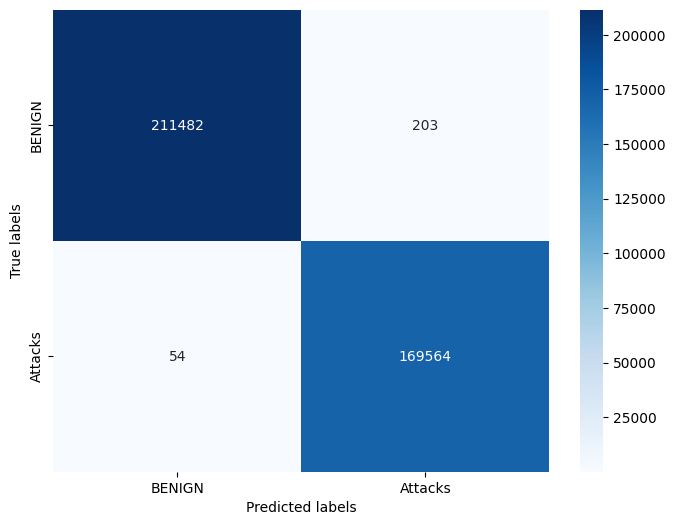

In [89]:
# Compute the confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Hyperparameter tuning

In [164]:
import mlflow
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Set the MLflow tracking URI and experiment
mlflow.set_tracking_uri("http://localhost:5001")  # Ensure this URI is correct
mlflow.set_experiment("hyperparameter_tuning")

# Define parameter grid for XGBoost
param_dist_xgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}

# Initialize RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_distributions=param_dist_xgb,
    n_iter=50,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Ensure any existing runs are closed
mlflow.end_run()

# Start a new MLflow run within a context manager
with mlflow.start_run(run_name="xgb_tuned"):
    # Fit random search to the data
    random_search_xgb.fit(X_train_final, y_train)

    # Retrieve and log the best parameters
    best_params = random_search_xgb.best_params_
    print("Best Hyperparameters for XGBoost:", best_params)
    mlflow.log_params(best_params)

    # Optionally log the model
    mlflow.sklearn.log_model(random_search_xgb.best_estimator_, "xgb_model_mlflow")

    # Save the best parameters to a JSON file (optional, not recommended within the context block)
    model_name = "XGB"
    save_best_params_to_json(model_name, best_params)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   4.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   5.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   5.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   5.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   7.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   7.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1,

2024/09/22 21:59:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/22 21:59:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run xgb_tuned at: http://localhost:5001/#/experiments/469953685001500752/runs/f38f6b2f8afc412298e24d22d93891b0.
2024/09/22 21:59:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/469953685001500752.


In [96]:
import mlflow
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for XGBoost
param_dist_xgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}

# Initialize RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_distributions=param_dist_xgb,
    n_iter=50,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Set MLflow experiment
mlflow.set_experiment("hyperparameter_tuning")
mlflow.set_tracking_uri("http://localhost:5001")

# Ensure any existing runs are closed
mlflow.end_run()

# Start a new MLflow run
with mlflow.start_run(run_name="xgb_tuned"):
    # Fit the model
    random_search_xgb.fit(X_train_final, y_train)

    # Log the best parameters and the model
    best_params = random_search_xgb.best_params_
    mlflow.log_params(best_params)
    mlflow.sklearn.log_model(random_search_xgb.best_estimator_, "xgb_model_mlflow")

    save_best_params_to_json(model_name, best_params)

2024/09/22 19:57:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run enthused-bug-971 at: http://localhost:5001/#/experiments/723724480696361092/runs/53c123eee90d438e8c1a1de71679ee0b.
2024/09/22 19:57:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/723724480696361092.


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   5.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   5.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   5.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   5.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   5.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   7.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1,

/Users/Internship/Documents/GitHub/Capstone_Notebook/env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   8.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   8.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   8.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   8.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   8.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   8.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   7.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time

2024/09/22 19:59:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/22 19:59:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run xgb_tuned at: http://localhost:5001/#/experiments/469953685001500752/runs/d04dc787c11f4c4d9ef167b5aa622747.
2024/09/22 19:59:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/469953685001500752.


## Evaluation Steps

In [97]:
# Evaluate the best XGBoost model on the test set
best_xgb = random_search_xgb.best_estimator_
y_pred = best_xgb.predict(X_test_final)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper.append(['XGB (Tuned)', accuracy, recall, precision, f1, mcc])
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

Accuracy: 99.88277039519751
Recall: 99.88277039519751
Precision: 99.88280236815585
F1 Score: 99.88277481069808
MCC: 99.76269325217586


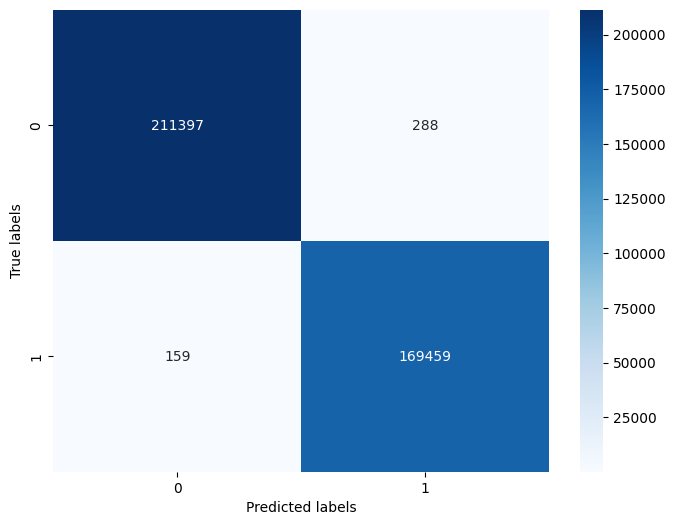

In [98]:
cm_xgb_tuned = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb_tuned, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 3. Decision Tree

### Training

In [99]:
# Initialize the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
mlflow.set_experiment("training_by_default")
with mlflow.start_run(run_name="decision_tree"):
    # Fit the RandomForest model on the training data
    dt.fit(X_train_final, y_train)

2024/09/22 20:00:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run decision_tree at: http://localhost:5001/#/experiments/723724480696361092/runs/cc4eb2ac163c451199aaf856a485962e.
2024/09/22 20:00:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/723724480696361092.


## k- fold cross

In [100]:
from sklearn.model_selection import  cross_validate

# Define K-Fold cross-validator
kfold_validation = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the classifier
DT_cross = DecisionTreeClassifier(random_state=42)

# Perform k-fold cross-validation with multiple scoring metrics
DT_cross_scores = cross_validate(DT_cross, X, y, cv=kfold_validation, scoring='accuracy', return_train_score=True)

# Print the scores for each fold and metric
print("Average Accuracy Score:", DT_cross_scores['test_score'].mean())
print(DT_cross_scores)

Average Accuracy Score: 0.9985984892875652
{'fit_time': array([19.94921923, 19.517308  , 19.37383699, 19.98941898, 20.75159407]), 'score_time': array([0.04112983, 0.03222585, 0.02886987, 0.02910209, 0.03233886]), 'test_score': array([0.99851037, 0.99858381, 0.99864674, 0.9986415 , 0.99861003]), 'train_score': array([0.9998374 , 0.99982429, 0.99983084, 0.99983215, 0.99984527])}


In [101]:
DT_cross_scores

{'fit_time': array([19.94921923, 19.517308  , 19.37383699, 19.98941898, 20.75159407]),
 'score_time': array([0.04112983, 0.03222585, 0.02886987, 0.02910209, 0.03233886]),
 'test_score': array([0.99851037, 0.99858381, 0.99864674, 0.9986415 , 0.99861003]),
 'train_score': array([0.9998374 , 0.99982429, 0.99983084, 0.99983215, 0.99984527])}

### Testing

In [102]:
# Make predictions on the test data
y_pred_dt = dt.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score.append(['Decision Tree ', accuracy, recall, precision, f1, mcc])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

2024/09/22 20:02:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run unleashed-ram-959 at: http://localhost:5001/#/experiments/723724480696361092/runs/123646c56edb47ff8af12805fb04a7d4.
2024/09/22 20:02:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/723724480696361092.


Accuracy: 99.88277039519751
Recall: 99.88277039519751
Precision: 99.88280236815585
F1 Score: 99.88277481069808
MCC: 99.76269325217586


### Confusion Matrix

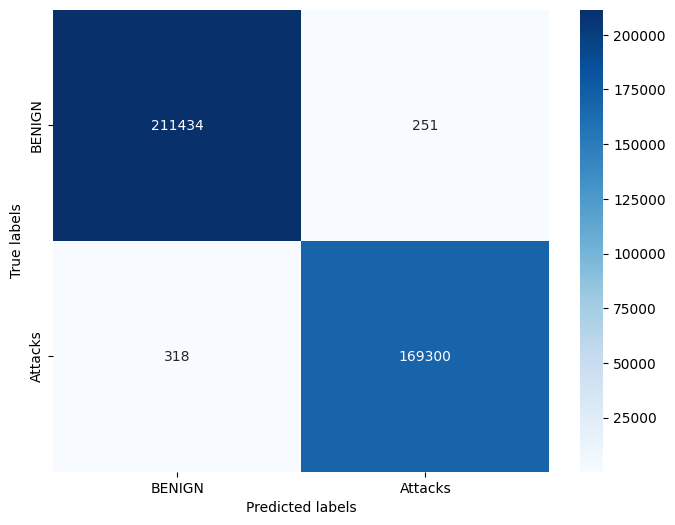

In [103]:
# Compute the confusion matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Hyperparameter Tuning

In [104]:
import mlflow
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for Decision Tree
param_dist_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

# Initialize RandomizedSearchCV for Decision Tree
random_search_dt = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist_dt,
    n_iter=50,  # Adjusted number of iterations
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Set the MLflow tracking URI and experiment
mlflow.set_tracking_uri("http://localhost:5001")  # Ensure this URI is correct
mlflow.set_experiment("hyperparameter_tuning")

# Ensure any existing runs are closed
mlflow.end_run()

# Start a new MLflow run within a context manager
with mlflow.start_run(run_name="decision_tree_tuned"):
    # Fit random search to the data
    random_search_dt.fit(X_train_final, y_train)

    # Retrieve and log the best parameters
    best_params = random_search_dt.best_params_
    print("Best Hyperparameters for Decision Tree:", best_params)
    mlflow.log_params(best_params)

    # Optionally log the model
    mlflow.sklearn.log_model(random_search_dt.best_estimator_, "Decision_Tree_model_mlflow")

    # Save the best parameters to a JSON file (optional, not recommended within the context block)
    model_name = "Decision Tree"
    save_best_params_to_json(model_name, best_params)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   1.5s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   1.6s
[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, splitter=best; total time=   1.6s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   1.6s
[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, splitter=best; total time=   2.1s
[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, splitter=best; total time=   2.1s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, splitter=best; total ti

2024/09/22 20:03:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/22 20:03:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run decision_tree_tuned at: http://localhost:5001/#/experiments/469953685001500752/runs/994f24059e7941ec80f40605d640a9b6.
2024/09/22 20:03:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/469953685001500752.


### Evaluation Steps

In [105]:
best_dt = random_search_dt.best_estimator_
y_pred = best_dt.predict(X_test_final)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper.append(['Decision Tree (Tuned)', accuracy, recall, precision, f1, mcc])
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

Accuracy: 99.89693236087835
Recall: 99.89693236087835
Precision: 99.89694031687861
F1 Score: 99.89693407923521
MCC: 99.79133637842999


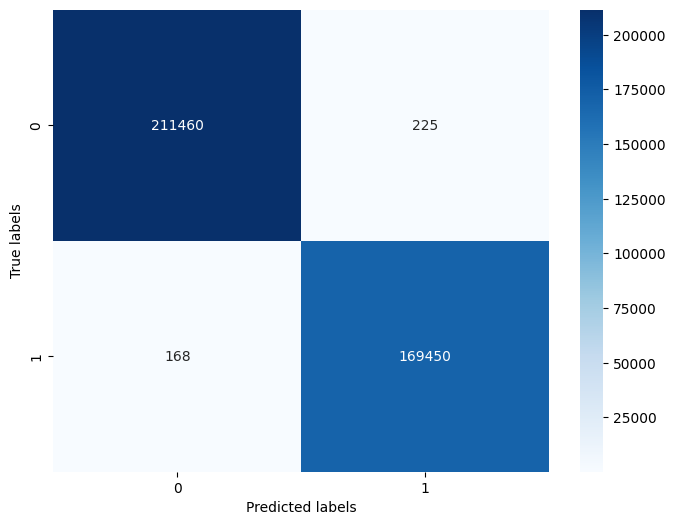

In [106]:
cm_dt_tuned = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt_tuned, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 4. Logistic Regression: While simpler, logistic regression can still provide solid results, especially when regularized using techniques like L2 (Ridge) or L1 (Lasso).

### Training

In [107]:
# Initialize the Logistic Regression model
lr = LogisticRegression(random_state=42)
mlflow.set_experiment("training_by_default")

with mlflow.start_run(run_name="logistic_regression"):
    # Fit the RandomForest model on the training data
    lr.fit(X_train_final, y_train)

/Users/Internship/Documents/GitHub/Capstone_Notebook/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2024/09/22 20:03:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run logistic_regression at: http://localhost:5001/#/experiments/723724480696361092/runs/286a3efd3ab747f9975ceab050e8d660.
2024/09/22 20:03:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/723724480696361092.


## k-fold cross validation

In [109]:
from sklearn.model_selection import  cross_validate

# Define K-Fold cross-validator
kfold_validation = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the classifier
lr_cross = LogisticRegression(random_state=42)

# Perform k-fold cross-validation with multiple scoring metrics
lr_cross_scores = cross_validate(lr_cross, X, y, cv=kfold_validation, scoring='accuracy', return_train_score=True)

# Print the scores for each fold and metric
print("Average Accuracy Score:", lr_cross_scores['test_score'].mean())
print(lr_cross_scores)

/Users/Internship/Documents/GitHub/Capstone_Notebook/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Internship/Documents/GitHub/Capstone_Notebook/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt

Average Accuracy Score: 0.8048501089498294
{'fit_time': array([3.94299603, 3.74305606, 3.95113611, 3.92081499, 3.73666787]), 'score_time': array([0.02396894, 0.01844382, 0.01904082, 0.01582289, 0.01585627]), 'test_score': array([0.80406185, 0.80533118, 0.80568159, 0.80384577, 0.80533016]), 'train_score': array([0.80666007, 0.80421712, 0.80543426, 0.80356173, 0.80454127])}


/Users/Internship/Documents/GitHub/Capstone_Notebook/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [110]:
lr_cross_scores

{'fit_time': array([3.94299603, 3.74305606, 3.95113611, 3.92081499, 3.73666787]),
 'score_time': array([0.02396894, 0.01844382, 0.01904082, 0.01582289, 0.01585627]),
 'test_score': array([0.80406185, 0.80533118, 0.80568159, 0.80384577, 0.80533016]),
 'train_score': array([0.80666007, 0.80421712, 0.80543426, 0.80356173, 0.80454127])}

### Testing

In [111]:
# Make predictions on the test data
y_pred = lr.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score.append(['Logistic Regression', accuracy, recall, precision, f1, mcc])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc }
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

2024/09/22 20:57:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-stork-209 at: http://localhost:5001/#/experiments/723724480696361092/runs/326b09432cae4fe9b251563466168485.
2024/09/22 20:57:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/723724480696361092.


Accuracy: 94.79311728467911
Recall: 94.79311728467911
Precision: 94.94816126603928
F1 Score: 94.80471629921313
MCC: 89.64561382273456


### Confusion matrix

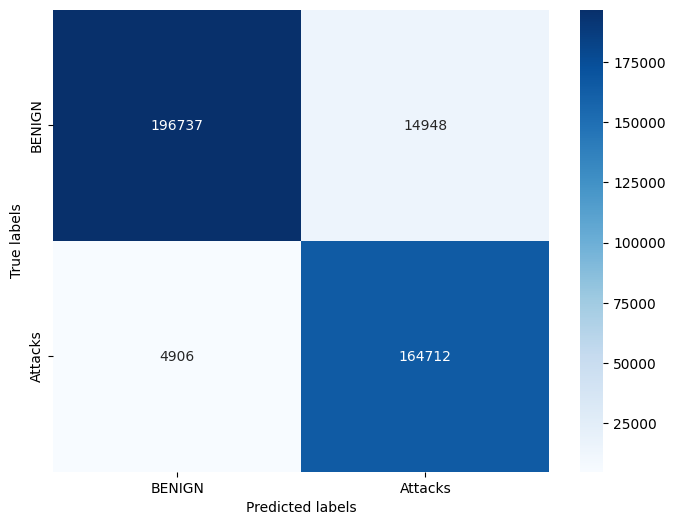

In [112]:
# Compute the confusion matrix
cm_lr = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Hyperparameter Tuning

In [113]:
import mlflow
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l2'],           # Simplified to only 'l2' for now to reduce complexity
    'C': [0.1, 1.0],             # Reduced range for C
    'solver': ['liblinear'],     # Using 'liblinear' as it's often faster for smaller datasets
    'max_iter': [1000],          # Standard max_iter to see if it converges
    'tol': [1e-4]                # Standard tolerance
}

# Initialize the Logistic Regression model
log_model = LogisticRegression(random_state=42)

# Initialize GridSearchCV
clf = GridSearchCV(log_model, param_grid=param_grid, cv=3, verbose=True, n_jobs=-1, scoring='f1_weighted')

# Set the MLflow tracking URI and experiment
mlflow.set_tracking_uri("http://localhost:5001")  # Ensure this URI is correct
mlflow.set_experiment("hyperparameter_tuning")

# Ensure any existing runs are closed
mlflow.end_run()

# Start a new MLflow run within a context manager
with mlflow.start_run(run_name="logistic_regression_tuned"):
    # Fit GridSearchCV to the data
    clf.fit(X_train_final, y_train)

    # Retrieve and log the best parameters
    best_params = clf.best_params_
    print("Best parameters found: ", best_params)
    print("Best cross-validated score: ", clf.best_score_)

    # Log the best parameters
    mlflow.log_params(best_params)

    # Optionally log the model
    mlflow.sklearn.log_model(clf.best_estimator_, "logistic_regression_model_mlflow")

    # Save the best parameters to a JSON file
    model_name = "Logistic Regression"
    save_best_params_to_json(model_name, best_params)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters found:  {'C': 1.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
Best cross-validated score:  0.9516526334774703


2024/09/22 21:11:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/22 21:11:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run logistic_regression_tuned at: http://localhost:5001/#/experiments/469953685001500752/runs/c077134de618411e93e848a34b1569c7.
2024/09/22 21:11:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/469953685001500752.


## Evaluation Steps

In [114]:
# Get the best model from GridSearchCV
best_lr = clf.best_estimator_

# Validating the model with training data (optional)
train_score = best_lr.score(X_train_final, y_train)
print(f'Accuracy on training set: {train_score:.3f}')

# Testing the best logistic regression model (after hyperparameter tuning)
y_pred = best_lr.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

# Append the results to the hyperparameter-tuned score list
score_hyper.append(['Logistic Regression (Tuned)', accuracy, recall, precision, f1, mcc])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc }
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"MCC: {mcc * 100:.2f}%")

Accuracy on training set: 0.952


2024/09/22 21:11:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run nebulous-penguin-784 at: http://localhost:5001/#/experiments/469953685001500752/runs/32a58479da06409daf7669860a64b602.
2024/09/22 21:11:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/469953685001500752.


Accuracy: 95.20%
Recall: 95.20%
Precision: 95.33%
F1 Score: 95.21%
MCC: 90.44%


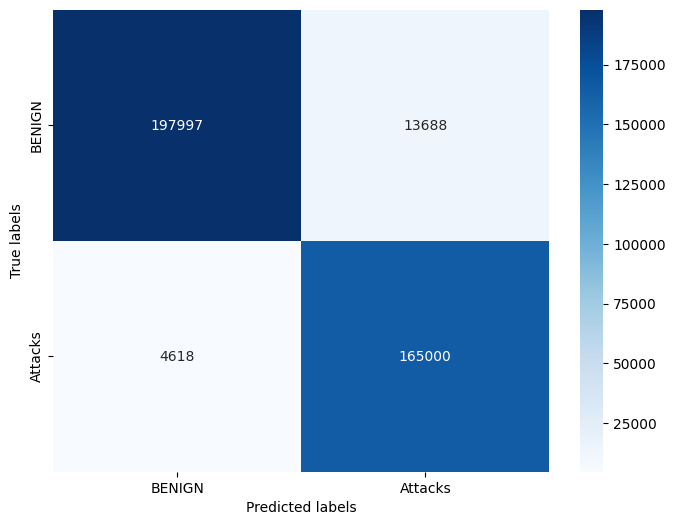

In [115]:
# Compute the confusion matrix for tuned Logistic Regression
cm_lr_tuned = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_tuned, annot=True, cmap='Blues', fmt='g', xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 5. Naive Bayes: This model is quick and easy to implement but may be limited by its assumptions of feature independence.

### Training

In [116]:
# Initialize the Naive Bayes model
nb = GaussianNB()
mlflow.set_experiment("training_by_default")


with mlflow.start_run(run_name="naive_bayes"):
    # Fit the RandomForest model on the training data
    nb.fit(X_train_final, y_train)

2024/09/22 21:11:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run naive_bayes at: http://localhost:5001/#/experiments/723724480696361092/runs/6d3f72b749cc4f62aef383e859c6657e.
2024/09/22 21:11:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/723724480696361092.


## k-fold cross validation

In [117]:
from sklearn.model_selection import  cross_validate

# Define K-Fold cross-validator
kfold_validation = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the classifier
nb_cross = GaussianNB()

# Perform k-fold cross-validation with multiple scoring metrics
nb_cross_scores = cross_validate(nb_cross, X, y, cv=kfold_validation, scoring='accuracy', return_train_score=True)

# Print the scores for each fold and metric
print("Average Accuracy Score:", nb_cross_scores['test_score'].mean())
print(nb_cross_scores)

Average Accuracy Score: 0.5946015349138691
{'fit_time': array([0.59350204, 0.46086407, 0.39517188, 0.37929296, 0.38714218]), 'score_time': array([0.06072092, 0.0597682 , 0.05976415, 0.05697513, 0.05278683]), 'test_score': array([0.55831043, 0.55552525, 0.55508232, 0.74698795, 0.55710172]), 'train_score': array([0.55622767, 0.5572767 , 0.55704518, 0.74563798, 0.55604205])}


In [118]:
nb_cross_scores

{'fit_time': array([0.59350204, 0.46086407, 0.39517188, 0.37929296, 0.38714218]),
 'score_time': array([0.06072092, 0.0597682 , 0.05976415, 0.05697513, 0.05278683]),
 'test_score': array([0.55831043, 0.55552525, 0.55508232, 0.74698795, 0.55710172]),
 'train_score': array([0.55622767, 0.5572767 , 0.55704518, 0.74563798, 0.55604205])}

### Testing

In [119]:
# Make predictions on the test data
y_pred = nb.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score.append(['Naive Bayes', accuracy, recall, precision, f1, mcc])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc, }
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

2024/09/22 21:11:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run crawling-shrimp-873 at: http://localhost:5001/#/experiments/723724480696361092/runs/a25f476105aa484d8d71b2bc3ff572d4.
2024/09/22 21:11:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/723724480696361092.


Accuracy: 67.39863048546694
Recall: 67.39863048546694
Precision: 80.07070434153913
F1 Score: 65.18595143149687
MCC: 47.82614215093632


### Confusion Matrix

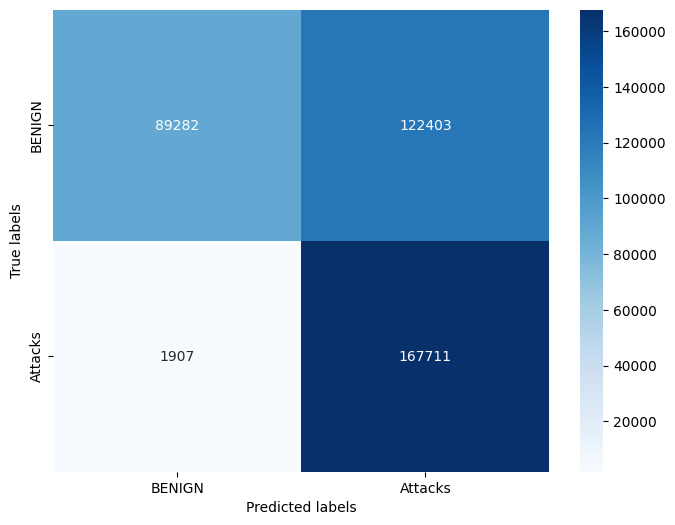

In [120]:
cm_naive_bayes = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_naive_bayes, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Hyperparameter Tuning

In [121]:
import mlflow
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for Gaussian Naive Bayes
param_dist_nb = {
    'var_smoothing': [1e-09, 1e-08]  # Reduced range to simplify
}

# Initialize RandomizedSearchCV for Gaussian Naive Bayes
random_search_nb = RandomizedSearchCV(
    estimator=GaussianNB(),
    param_distributions=param_dist_nb,
    n_iter=10,  # Adjusted number of iterations due to fewer parameters
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Set the MLflow tracking URI and experiment
mlflow.set_tracking_uri("http://localhost:5001")  # Ensure this URI is correct
mlflow.set_experiment("hyperparameter_tuning")

# Ensure any existing runs are closed
mlflow.end_run()

# Start a new MLflow run within a context manager
with mlflow.start_run(run_name="naive_bayes_tuned"):
    # Fit RandomizedSearchCV to the data
    random_search_nb.fit(X_train_final, y_train)

    # Retrieve and log the best parameters
    best_params = random_search_nb.best_params_
    print("Best Hyperparameters for Gaussian Naive Bayes:", best_params)
    mlflow.log_params(best_params)

    # Optionally log the model
    mlflow.sklearn.log_model(random_search_nb.best_estimator_, "Naive_Bayes_model_mlflow")

    # Save the best parameters to a JSON file (optional, not recommended within the context block)
    model_name = "Naive Bayes"
    save_best_params_to_json(model_name, best_params)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/Internship/Documents/GitHub/Capstone_Notebook/env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ................................var_smoothing=1e-09; total time=   1.8s
[CV] END ................................var_smoothing=1e-08; total time=   1.8s
[CV] END ................................var_smoothing=1e-09; total time=   1.9s
[CV] END ................................var_smoothing=1e-08; total time=   1.9s
[CV] END ................................var_smoothing=1e-09; total time=   1.9s
[CV] END ................................var_smoothing=1e-08; total time=   1.9s
Best Hyperparameters for Gaussian Naive Bayes: {'var_smoothing': 1e-08}


2024/09/22 21:17:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/22 21:17:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run naive_bayes_tuned at: http://localhost:5001/#/experiments/469953685001500752/runs/590aabcb28034b2f9ec893126f2db488.
2024/09/22 21:17:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/469953685001500752.


## Evaluation steps

In [122]:
# Evaluate the best Naive Bayes model on the test set
best_nb = random_search_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test_final)


accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

# Append to the score_hyper list
score_hyper.append(['Naive bayes (Tuned)', accuracy, recall, precision, f1, mcc])
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

Accuracy: 67.39863048546694
Recall: 67.39863048546694
Precision: 80.07070434153913
F1 Score: 65.18595143149687
MCC: 47.82614215093632


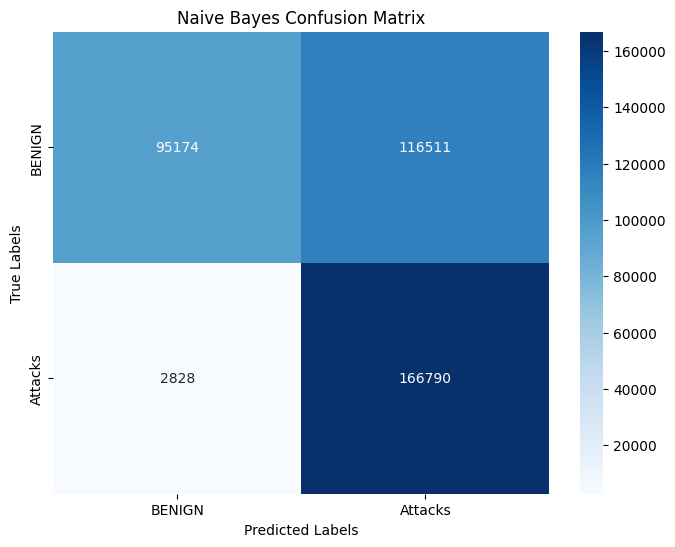

In [123]:
cm_nb_tunned = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb_tunned, annot=True, cmap='Blues', fmt='g',
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# DataFrames for Model Metrics:

## After collecting the results in score and score_hyper , I have created a new DataFrames to display the results (accuracy, recall, etc.), as shown below

In [124]:
# Define the columns for the tables
columns = ['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'MCC']

# Create a DataFrame for the normal training results
df_normal = pd.DataFrame(score, columns=columns)

# Create a DataFrame for the hyperparameter tuning results
df_hyper = pd.DataFrame(score_hyper, columns=columns)

In [125]:
print("Normal Training Results:")
df_normal

Normal Training Results:


,Model,Accuracy,Recall,Precision,F1 Score,MCC
0,Gradient Boosting Machines,0.998914,0.998914,0.998914,0.998914,0.997802
1,Gradient Boosting Model,0.999326,0.999326,0.999326,0.999326,0.998636
2,Decision Tree model,0.998828,0.998828,0.998828,0.998828,0.997627
3,Gradient Boosting Machines,0.947931,0.947931,0.949482,0.948047,0.896456
4,Gradient Boosting Machines,0.673986,0.673986,0.800707,0.651860,0.478261


In [126]:
print("\nHyperparameter Tuning Results:")
df_hyper


Hyperparameter Tuning Results:


,Model,Accuracy,Recall,Precision,F1 Score,MCC
0,Random Forest (Tuned),0.998888,0.998888,0.998888,0.998888,0.997749
1,XGB (Tuned),0.998828,0.998828,0.998828,0.998828,0.997627
2,Decision Tree (Tuned),0.998969,0.998969,0.998969,0.998969,0.997913
3,Logistic Regression (Tuned),0.951991,0.951991,0.953271,0.952091,0.904351
4,Naive bayes (Tuned),0.673986,0.673986,0.800707,0.651860,0.478261


## Plot and Save Multiple Confusion Matrices

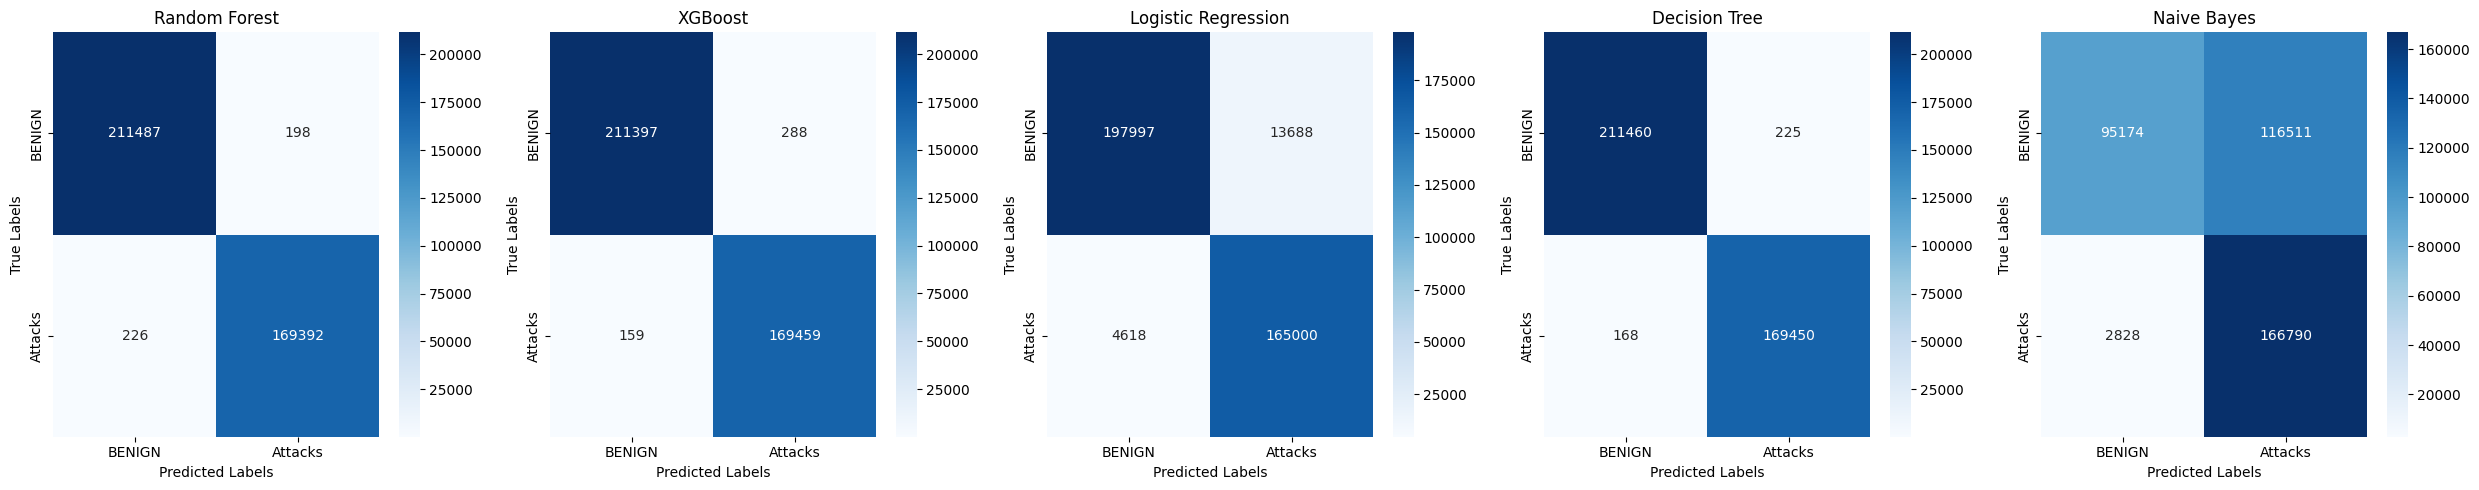

In [127]:
# Define the confusion matrices and titles in tuples for easier handling
confusion_matrices = [
    (cm_rfc_tuned, "Random Forest"),
    (cm_xgb_tuned, "XGBoost"),
    (cm_lr_tuned, "Logistic Regression"),
    (cm_dt_tuned, "Decision Tree"),
    (cm_nb_tunned, "Naive Bayes")
]

# Setup the matplotlib figure and axes
num_matrices = len(confusion_matrices)
fig, axes = plt.subplots(nrows=1, ncols=num_matrices, figsize=(5 * num_matrices, 5))  # Adjust size as needed

# Check if only one row of subplots, make axes iterable
if num_matrices == 1:
    axes = [axes]

# Loop through the confusion matrices and corresponding axes
for ax, (cm, title) in zip(axes, confusion_matrices):
    # Plotting the confusion matrix using seaborn's heatmap function
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax, 
                xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
    ax.set_title(title)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

# Tight layout to ensure subplots do not overlap
plt.tight_layout()

# Save the figure
plt.savefig('all_confusion_matrices.png')
plt.show()

In [128]:
print(nb_cross_scores)
print(lr_cross_scores)
print(DT_cross_scores)
print(xgb_cross_scores)
print(rf_cross_scores)

{'fit_time': array([0.59350204, 0.46086407, 0.39517188, 0.37929296, 0.38714218]), 'score_time': array([0.06072092, 0.0597682 , 0.05976415, 0.05697513, 0.05278683]), 'test_score': array([0.55831043, 0.55552525, 0.55508232, 0.74698795, 0.55710172]), 'train_score': array([0.55622767, 0.5572767 , 0.55704518, 0.74563798, 0.55604205])}
{'fit_time': array([3.94299603, 3.74305606, 3.95113611, 3.92081499, 3.73666787]), 'score_time': array([0.02396894, 0.01844382, 0.01904082, 0.01582289, 0.01585627]), 'test_score': array([0.80406185, 0.80533118, 0.80568159, 0.80384577, 0.80533016]), 'train_score': array([0.80666007, 0.80421712, 0.80543426, 0.80356173, 0.80454127])}
{'fit_time': array([19.94921923, 19.517308  , 19.37383699, 19.98941898, 20.75159407]), 'score_time': array([0.04112983, 0.03222585, 0.02886987, 0.02910209, 0.03233886]), 'test_score': array([0.99851037, 0.99858381, 0.99864674, 0.9986415 , 0.99861003]), 'train_score': array([0.9998374 , 0.99982429, 0.99983084, 0.99983215, 0.99984527])}

## K-fold cross-validation

/var/folders/83/s9_py62d54b6v0352dkn68_80000gp/T/ipykernel_11813/4217125467.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    0.5583
1    0.8041
2    0.9985
3    0.9993
4    0.9985
Name: Fold-1, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  formatted_df.iloc[:, 1:] = formatted_df.iloc[:, 1:].map(lambda x: f"{x:.4f}")
/var/folders/83/s9_py62d54b6v0352dkn68_80000gp/T/ipykernel_11813/4217125467.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    0.5555
1    0.8053
2    0.9986
3    0.9994
4    0.9987
Name: Fold-2, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  formatted_df.iloc[:, 1:] = formatted_df.iloc[:, 1:].map(lambda x: f"{x:.4f}")
/var/folders/83/s9_py62d54b6v0352dkn68_80000gp/T/ipykernel_11813/4217125467.py:20:

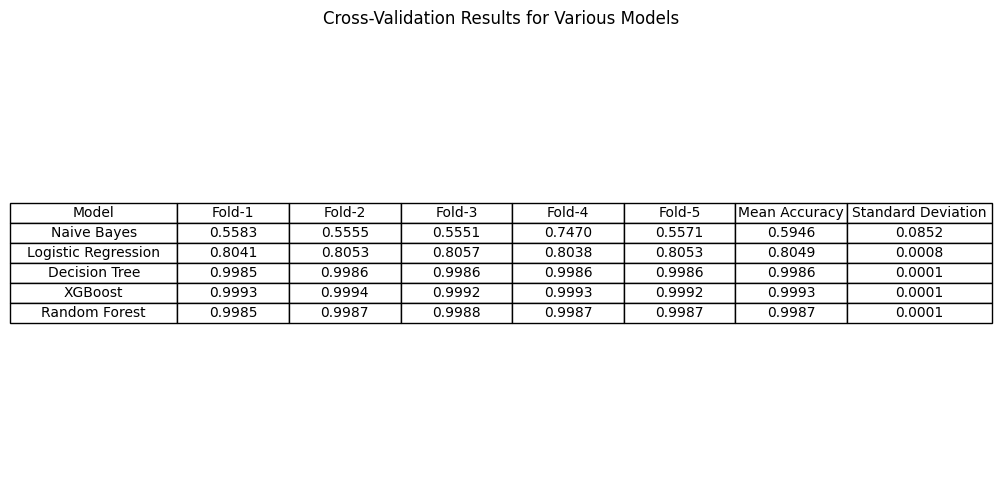

In [129]:
# Assuming the cross-validation score data is correct as provided
models = ['Naive Bayes', 'Logistic Regression', 'Decision Tree', 'XGBoost', 'Random Forest']
results = {
    'Model': models,
    'Fold-1': [scores['test_score'][0] for scores in [nb_cross_scores, lr_cross_scores, DT_cross_scores, xgb_cross_scores, rf_cross_scores]],
    'Fold-2': [scores['test_score'][1] for scores in [nb_cross_scores, lr_cross_scores, DT_cross_scores, xgb_cross_scores, rf_cross_scores]],
    'Fold-3': [scores['test_score'][2] for scores in [nb_cross_scores, lr_cross_scores, DT_cross_scores, xgb_cross_scores, rf_cross_scores]],
    'Fold-4': [scores['test_score'][3] for scores in [nb_cross_scores, lr_cross_scores, DT_cross_scores, xgb_cross_scores, rf_cross_scores]],
    'Fold-5': [scores['test_score'][4] for scores in [nb_cross_scores, lr_cross_scores, DT_cross_scores, xgb_cross_scores, rf_cross_scores]]
}

df_results = pd.DataFrame(results)

# Avoid converting to strings, calculate mean and standard deviation directly
df_results['Mean Accuracy'] = df_results[['Fold-1', 'Fold-2', 'Fold-3', 'Fold-4', 'Fold-5']].mean(axis=1)
df_results['Standard Deviation'] = df_results[['Fold-1', 'Fold-2', 'Fold-3', 'Fold-4', 'Fold-5']].std(axis=1)

# Formatting the output for display (not altering the actual DataFrame)
formatted_df = df_results.copy()
formatted_df.iloc[:, 1:] = formatted_df.iloc[:, 1:].map(lambda x: f"{x:.4f}")

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

# Creating the table
table = ax.table(cellText=formatted_df.values, colLabels=formatted_df.columns, cellLoc='center', loc='center', colWidths=[0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.13])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Add a title
plt.title('Cross-Validation Results for Various Models')

# Save the figure
plt.savefig('model_performance_table.png')

# Display the plot
plt.show()

In [130]:
nb_cross_scores

{'fit_time': array([0.59350204, 0.46086407, 0.39517188, 0.37929296, 0.38714218]),
 'score_time': array([0.06072092, 0.0597682 , 0.05976415, 0.05697513, 0.05278683]),
 'test_score': array([0.55831043, 0.55552525, 0.55508232, 0.74698795, 0.55710172]),
 'train_score': array([0.55622767, 0.5572767 , 0.55704518, 0.74563798, 0.55604205])}

# -------------------Feature Selected-------------------------

# Training models with features selected

In [131]:
X_train_fs = X_train_final[feature_selected]
X_test_fs = X_test_final[feature_selected]

## 1. Random Forest Classifier

In [132]:
score_fs = []  # For normal training results
score_hyper_fs = []  # For hyperparameter tuning results

### Training 

In [133]:
rfc_fs = RandomForestClassifier(random_state=42)
mlflow.set_experiment("training_fs_by_default")


with mlflow.start_run(run_name="rfc_fs_model"):
    # Fit the RandomForest model on the training data
    rfc_fs.fit(X_train_fs, y_train)

2024/09/22 21:18:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfc_fs_model at: http://localhost:5001/#/experiments/743458130391879532/runs/748c48adcfb84683be425456d20cbda5.
2024/09/22 21:18:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/743458130391879532.


### Testing

In [134]:
y_pred = rfc_fs.predict(X_test_fs)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_fs.append(['Random Forest', accuracy, recall, precision, f1, mcc])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()


print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

2024/09/22 21:18:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run spiffy-moose-283 at: http://localhost:5001/#/experiments/743458130391879532/runs/2aeb88d009544ead8ad742de403958e9.
2024/09/22 21:18:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/743458130391879532.


Accuracy: 99.89404751601745
Recall: 99.89404751601745
Precision: 99.89404687866877
F1 Score: 99.89404701928804
MCC: 99.78548240955985


### Confusion matrix

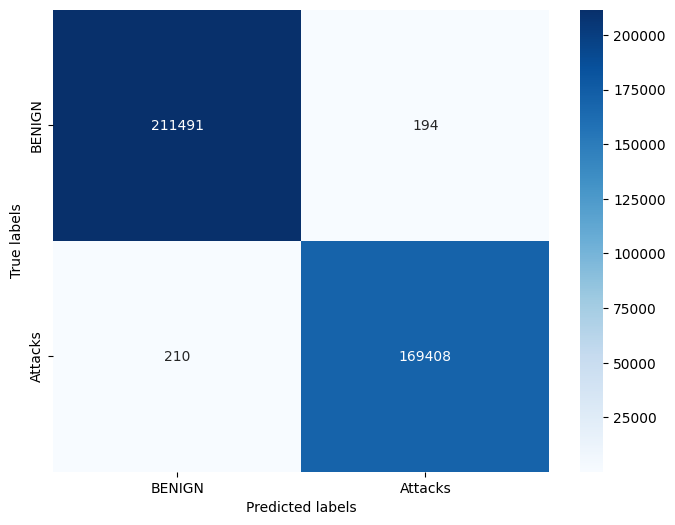

In [135]:
cm_rf = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

### Hyperparameter Tuning

In [136]:
# Define parameter grid
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=100,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
mlflow.set_experiment("hyperparameter_fs_tuning")

mlflow.start_run(run_name="random_forest_fs_tuned")
# Fit random search to the data
random_search.fit(X_train_fs, y_train)

# Print best parameters
print("Best Hyperparameters:", random_search.best_params_)



# Save the best parameters
model_name = "Random Forest fs"
best_params = random_search.best_params_
mlflow.log_params(best_params)

# Optionally log the model as well
mlflow.sklearn.log_model(random_search.best_estimator_, "random_forest_fs_model_mlflow")

save_best_fs_params_to_json(model_name, best_params)

/Users/Internship/Documents/GitHub/Capstone_Notebook/env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=100. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  40.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  42.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  42.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  41.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  41.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  46.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END max_depth=10, min_samples_l

2024/09/22 21:28:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Evaluation Steps

In [137]:
# Evaluate the best model on the test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_fs)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper_fs.append(['Random Forest (Tuned)', accuracy, recall, precision, f1, mcc])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

2024/09/22 21:28:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run random_forest_fs_tuned at: http://localhost:5001/#/experiments/409427863574455025/runs/6d58c004556d4bfabafa4a4c8aa9a2c4.
2024/09/22 21:28:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/409427863574455025.


Accuracy: 99.88906460216678
Recall: 99.88906460216678
Precision: 99.88906385019074
F1 Score: 99.88906391946495
MCC: 99.77539329636281


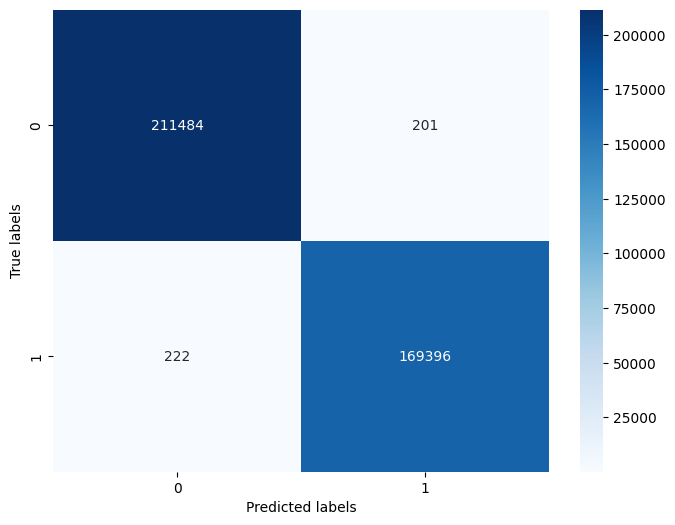

In [138]:
cm_rfc_fs_tunned = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rfc_fs_tunned, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 2. XGB

## Training

In [139]:
# Initialize the XGBoost model
xgb_fs = XGBClassifier(random_state=42)
mlflow.set_experiment("training_fs_by_default")


with mlflow.start_run(run_name="xgb_fs_model"):
    # Fit the RandomForest model on the training data
    xgb_fs.fit(X_train_fs, y_train)

2024/09/22 21:28:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run xgb_fs_model at: http://localhost:5001/#/experiments/743458130391879532/runs/39d61c96c3ef40a182c21367d4c4a259.
2024/09/22 21:28:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/743458130391879532.


In [140]:
# Make predictions on the test data
y_pred = xgb_fs.predict(X_test_fs)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_fs.append(['XGB Model', accuracy, recall, precision, f1, mcc])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

2024/09/22 21:28:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run bald-crane-627 at: http://localhost:5001/#/experiments/743458130391879532/runs/0b46507d8b3e436592bf0b787ac90916.
2024/09/22 21:28:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/743458130391879532.


Accuracy: 99.92945243021953
Recall: 99.92945243021953
Precision: 99.92948765350343
F1 Score: 99.9294554158305
MCC: 99.85720808971912


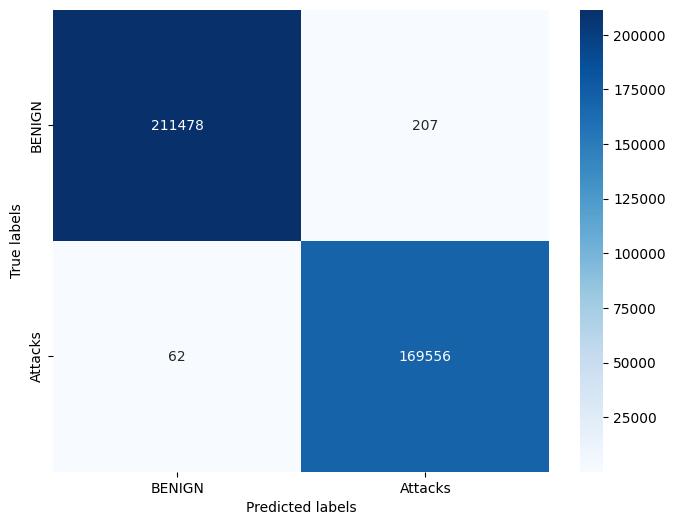

In [141]:
# Compute the confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Hyperparameter Tuning

In [142]:
# Define parameter grid for XGBoost
param_dist_xgb = {
    'n_estimators': [50, 100],  # Reduced to 2 values
    'learning_rate': [0.05, 0.1],  # Reduced to 2 values
    'max_depth': [3, 5],  # Reduced to 2 values
    'subsample': [0.8, 1.0],  # Reduced to 2 values
    'colsample_bytree': [0.8, 1.0],  # Reduced to 2 values
    'gamma': [0, 0.1]  # Reduced to 2 values
}

# Initialize RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_distributions=param_dist_xgb,
    n_iter=50,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
mlflow.set_experiment("hyperparameter_fs_tuning")

mlflow.start_run(run_name="xgb_fs_tuned")

# Fit random search to the data
random_search_xgb.fit(X_train_fs, y_train)


# Save the best parameters
model_name = "XGB fs"

best_params = random_search.best_params_
mlflow.log_params(best_params)

# Optionally log the model as well
mlflow.sklearn.log_model(random_search.best_estimator_, "xgb_model_fs_mlflow")


save_best_fs_params_to_json(model_name, best_params)

# Print best parameters for XGBoost
print("Best Hyperparameters for XGBoost:", random_search_xgb.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   4.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   4.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   4.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   4.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50, subsample=0.8; total time=   4.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   6.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   6.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1,

2024/09/22 21:31:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Hyperparameters for XGBoost: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}


In [143]:

# Evaluate the best XGBoost model on the test set
best_xgb = random_search_xgb.best_estimator_
y_pred = best_xgb.predict(X_test_fs)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper_fs.append(['XGB (Tuned)', accuracy, recall, precision, f1, mcc])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

2024/09/22 21:31:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run xgb_fs_tuned at: http://localhost:5001/#/experiments/409427863574455025/runs/385971478c524203b818277333c90974.
2024/09/22 21:31:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/409427863574455025.


Accuracy: 99.8649368087846
Recall: 99.8649368087846
Precision: 99.86495968895514
F1 Score: 99.86494087324527
MCC: 99.72657668597006


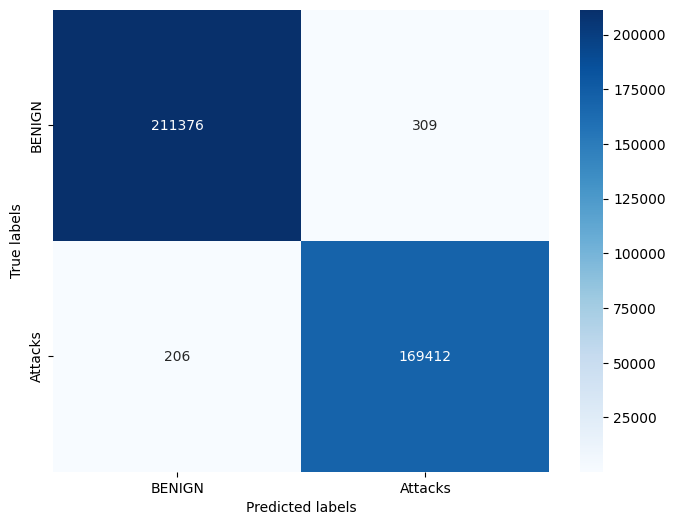

In [144]:
# Compute the confusion matrix
cm_xgb_fs_tunned = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb_fs_tunned, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 3. logistic regression

In [145]:
# Initialize the Logistic Regression model
lr_fs = LogisticRegression(random_state=42)
mlflow.set_experiment("training_fs_by_default")

with mlflow.start_run(run_name="logistic_regression_fs"):
    # Fit the RandomForest model on the training data
    lr_fs.fit(X_train_final, y_train)

/Users/Internship/Documents/GitHub/Capstone_Notebook/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2024/09/22 21:31:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run logistic_regression_fs at: http://localhost:5001/#/experiments/743458130391879532/runs/2fb6e9f919dc4902ae0c0fd29a7a6367.
2024/09/22 21:31:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/743458130391879532.


## Testing

In [146]:
# Make predictions on the test data
y_pred = lr_fs.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_fs.append(['Logistic Regression', accuracy, recall, precision, f1, mcc])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc, }
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

2024/09/22 21:31:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run defiant-crow-224 at: http://localhost:5001/#/experiments/743458130391879532/runs/8a6cd893801944dc9e60e9d49b047c3b.
2024/09/22 21:31:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/743458130391879532.


Accuracy: 94.79311728467911
Recall: 94.79311728467911
Precision: 94.94816126603928
F1 Score: 94.80471629921313
MCC: 89.64561382273456


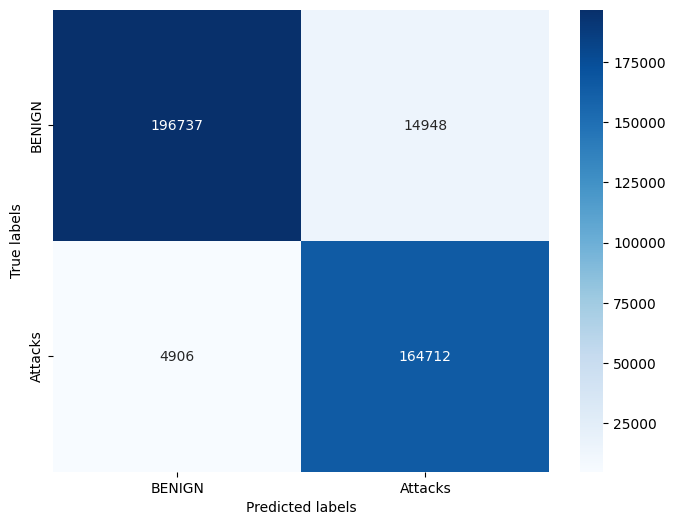

In [147]:
cm_lr_fs = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_fs, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Hyperparameter Tuning

In [148]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l2'],           # Simplified to only 'l2' for now to reduce complexity
    'C': [0.1, 1.0],             # Reduced range for C
    'solver': ['liblinear'],     # Using 'liblinear' as it's often faster for smaller datasets
    'max_iter': [1000],          # Standard max_iter to see if it converges
    'tol': [1e-4]                # Standard tolerance
}

# Initialize the Logistic Regression model
log_model = LogisticRegression(random_state=42)

# Initialize GridSearchCV
clf = GridSearchCV(log_model, param_grid=param_grid, cv=3, verbose=True, n_jobs=-1, scoring='f1_weighted')
mlflow.set_experiment("hyperparameter_fs_tuning")

mlflow.start_run(run_name="logistic_regression_fs_tuned")
# Apply best hyperparameters by fitting the model
clf.fit(X_train_final, y_train)

# Check out the best parameters found by GridSearchCV
print("Best parameters found: ", clf.best_params_)
print("Best cross-validated score: ", clf.best_score_)

# Save the best parameters
model_name = "Logistic Regression tunned fs"

best_params = clf.best_params_


mlflow.log_params(best_params)

# Optionally log the model as well
mlflow.sklearn.log_model(random_search.best_estimator_, "lr_model_fs_mlflow")


save_best_fs_params_to_json(model_name, best_params)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters found:  {'C': 1.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
Best cross-validated score:  0.9516526334774703


2024/09/22 21:42:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [149]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

# Append the results to the hyperparameter-tuned score list
score_hyper_fs.append(['Logistic Regression (Tuned)', accuracy, recall, precision, f1, mcc])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"MCC: {mcc * 100:.2f}%")

2024/09/22 21:42:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run logistic_regression_fs_tuned at: http://localhost:5001/#/experiments/409427863574455025/runs/3754d8fd84544ff78cd73cab78df0398.
2024/09/22 21:42:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/409427863574455025.


Accuracy: 94.79%
Recall: 94.79%
Precision: 94.95%
F1 Score: 94.80%
MCC: 89.65%


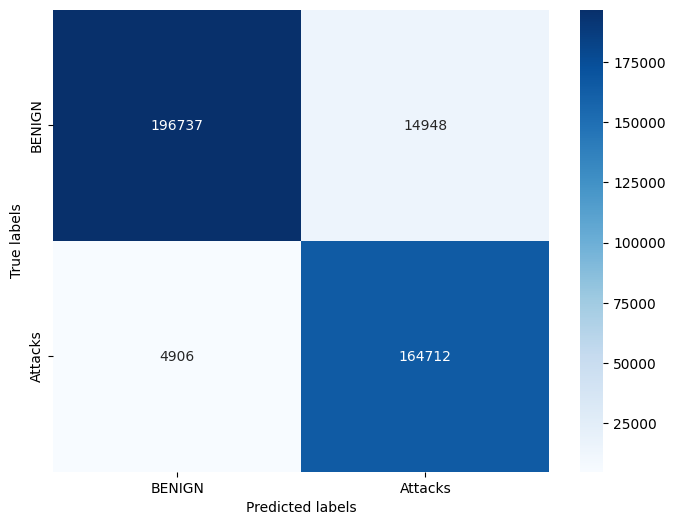

In [150]:
# Compute the confusion matrix
cm_lr_fs_tunned = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_fs_tunned, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 4. Naive Bayes

## Training

In [151]:
# Initialize the Naive Bayes model
nb_fs = GaussianNB()
mlflow.set_experiment("training_fs_by_default")


with mlflow.start_run(run_name="naive_bayes_fs"):
    # Fit the RandomForest model on the training data
    nb_fs.fit(X_train_final, y_train)

2024/09/22 21:42:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run naive_bayes_fs at: http://localhost:5001/#/experiments/743458130391879532/runs/c08e408b424348c1a8b80c04333fd1a6.
2024/09/22 21:42:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/743458130391879532.


## Testing

In [152]:
# Make predictions on the test data
y_pred = nb.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_fs.append(['Naive Bayes', accuracy, recall, precision, f1, mcc])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc, }
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

2024/09/22 21:42:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run melodic-snail-137 at: http://localhost:5001/#/experiments/743458130391879532/runs/b53387ebdf6340f6bbb8a8016e72e4f0.
2024/09/22 21:42:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/743458130391879532.


Accuracy: 67.39863048546694
Recall: 67.39863048546694
Precision: 80.07070434153913
F1 Score: 65.18595143149687
MCC: 47.82614215093632


## confusion matrix

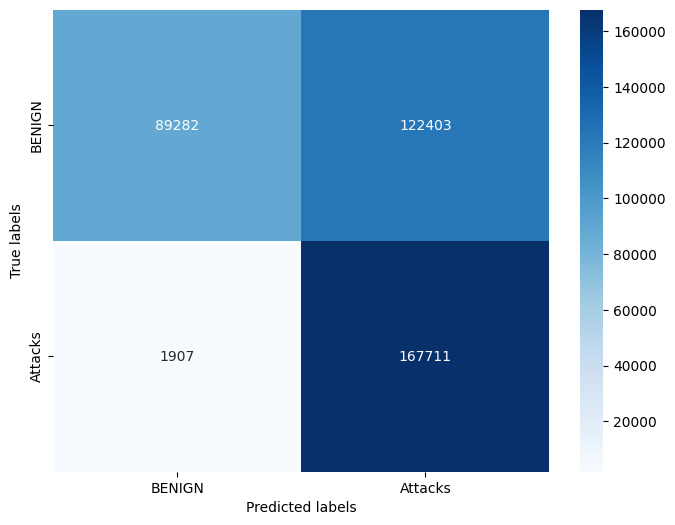

In [153]:
cm_naive_fs_bayes = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_naive_fs_bayes, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## hyperparameter tuning

In [154]:
# Define parameter grid for Gaussian Naive Bayes
param_dist_nb = {
    'var_smoothing': [1e-09, 1e-08]  # Reduced to 2 values
}

# Initialize RandomizedSearchCV for Gaussian Naive Bayes
random_search_nb = RandomizedSearchCV(
    estimator=GaussianNB(),
    param_distributions=param_dist_nb,
    n_iter=10,  # Fewer iterations due to limited parameters
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
mlflow.set_experiment("hyperparameter_fs_tuning")

mlflow.start_run(run_name="naive_bayes_fs_tuned")
# Fit RandomizedSearchCV to the training data
random_search_nb.fit(X_train_final, y_train)

# Print best parameters
print("Best Hyperparameters for Gaussian Naive Bayes fs:", random_search_nb.best_params_)

# Save the best parameters
model_name = "Naive Bayes fs"
best_params = random_search_nb.best_params_


mlflow.log_params(best_params)

# Optionally log the model as well
mlflow.sklearn.log_model(random_search.best_estimator_, "Naive_Bayes_fs_model_mlflow")


save_best_fs_params_to_json(model_name, best_params)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/Internship/Documents/GitHub/Capstone_Notebook/env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ................................var_smoothing=1e-09; total time=   1.2s
[CV] END ................................var_smoothing=1e-09; total time=   1.2s
[CV] END ................................var_smoothing=1e-09; total time=   1.3s
[CV] END ................................var_smoothing=1e-08; total time=   1.3s
[CV] END ................................var_smoothing=1e-08; total time=   1.3s
[CV] END ................................var_smoothing=1e-08; total time=   1.3s
Best Hyperparameters for Gaussian Naive Bayes fs: {'var_smoothing': 1e-08}


2024/09/22 21:42:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## evaluation matrix

In [155]:
# Evaluate the best Naive Bayes model on the test set
best_nb = random_search_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test_final)


accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

# Append to the score_hyper list
score_hyper_fs.append(['Naive bayes fs (Tuned)', accuracy, recall, precision, f1, mcc])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

2024/09/22 21:42:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run naive_bayes_fs_tuned at: http://localhost:5001/#/experiments/409427863574455025/runs/12300664a7a146d382f47c3be0024ec6.
2024/09/22 21:42:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/409427863574455025.


Accuracy: 67.39863048546694
Recall: 67.39863048546694
Precision: 80.07070434153913
F1 Score: 65.18595143149687
MCC: 47.82614215093632


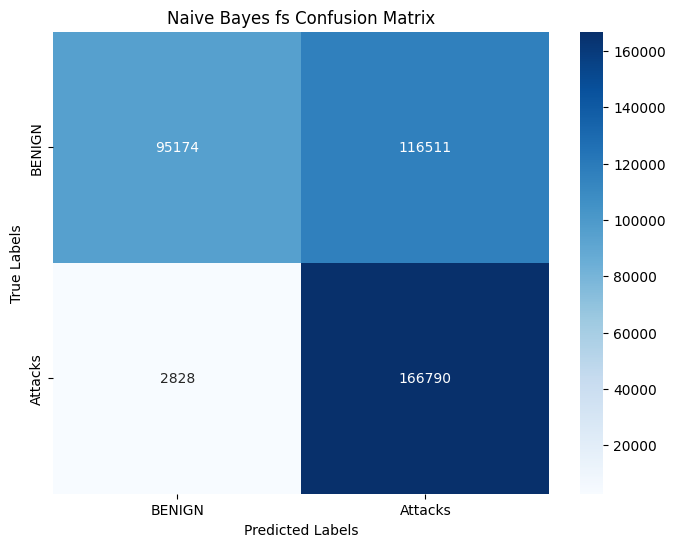

In [156]:
cm_nb_fs_tunned = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb_fs_tunned, annot=True, cmap='Blues', fmt='g',
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.title('Naive Bayes fs Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## 5. Decision Tree

## Training

In [157]:
# Initialize the Decision Tree model
dt_fs = DecisionTreeClassifier(random_state=42)
mlflow.set_experiment("training_fs_by_default")

with mlflow.start_run(run_name="decision_tree_fs"):
    # Fit the RandomForest model on the training data
    dt_fs.fit(X_train_final, y_train)

2024/09/22 21:42:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run decision_tree_fs at: http://localhost:5001/#/experiments/743458130391879532/runs/47d5c5ee21c845efb8676994dc348192.
2024/09/22 21:42:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/743458130391879532.


## Testing

In [158]:
# Make predictions on the test data
y_pred_dt = dt_fs.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_fs.append(['Decision Tree model', accuracy, recall, precision, f1, mcc])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

2024/09/22 21:42:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run gentle-crane-411 at: http://localhost:5001/#/experiments/743458130391879532/runs/468fbbdc3fd54dfb85cb320eb96dff7f.
2024/09/22 21:42:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/743458130391879532.


Accuracy: 67.39863048546694
Recall: 67.39863048546694
Precision: 80.07070434153913
F1 Score: 65.18595143149687
MCC: 47.82614215093632


## confusin matrix

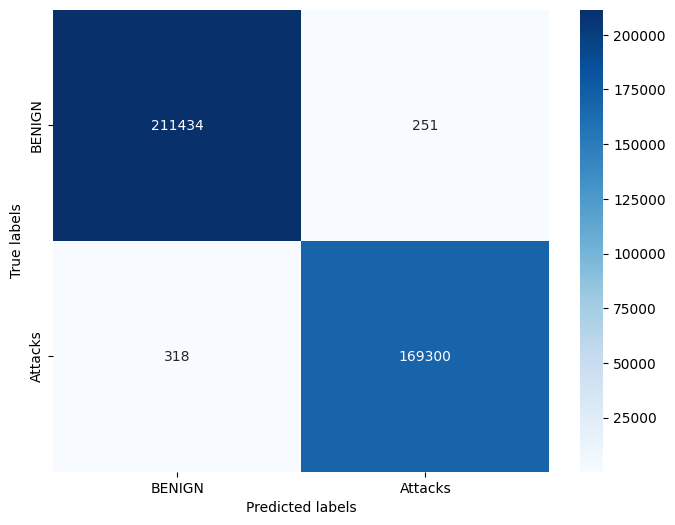

In [159]:
# Compute the confusion matrix for Decision Tree
cm_dt_fs = confusion_matrix(y_test, y_pred_dt)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt_fs, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## hyperparameter tuning

In [160]:
# Define parameter grid for Decision Tree
param_dist_dt = {
    'criterion': ['gini', 'entropy'],  # Criterion to split at nodes
    'max_depth': [None, 10, 20, 30],  # Depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf node
    'max_features': [None, 'sqrt', 'log2'],  # Maximum features considered at each split
    'splitter': ['best', 'random']  # Split strategy
}
# Initialize RandomizedSearchCV for Decision Tree
random_search_dt = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist_dt,
    n_iter=50,  # You can adjust this number
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
mlflow.set_experiment("hyperparameter_fs_tuning")

mlflow.start_run(run_name="decision_tree_fs_tuned")
# Fit random search to the data
random_search_dt.fit(X_train_final, y_train)

# Print best parameters for Decision Tree
print("Best Hyperparameters for Decision Tree fs:", random_search_dt.best_params_)

# Save the best parameters
model_name = "Decision Tree fs"

best_params = random_search_dt.best_params_


mlflow.log_params(best_params)

# Optionally log the model as well
mlflow.sklearn.log_model(random_search.best_estimator_, "Decision_Tree_model_fs_mlflow")



save_best_fs_params_to_json(model_name, best_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.7s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, splitter=best; total time=   1.4s
[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, splitter=best; total time=   1.4s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, splitter=best; total time=   1.2s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, splitter=best; total ti

2024/09/22 21:43:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [161]:
best_dt = random_search_dt.best_estimator_
y_pred = best_dt.predict(X_test_final)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper_fs.append(['Decision Tree (Tuned)', accuracy, recall, precision, f1, mcc])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

2024/09/22 21:43:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run decision_tree_fs_tuned at: http://localhost:5001/#/experiments/409427863574455025/runs/feb4ec3d284e44888d8188ba583e6f8a.
2024/09/22 21:43:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5001/#/experiments/409427863574455025.


Accuracy: 99.89693236087835
Recall: 99.89693236087835
Precision: 99.89694031687861
F1 Score: 99.89693407923521
MCC: 99.79133637842999


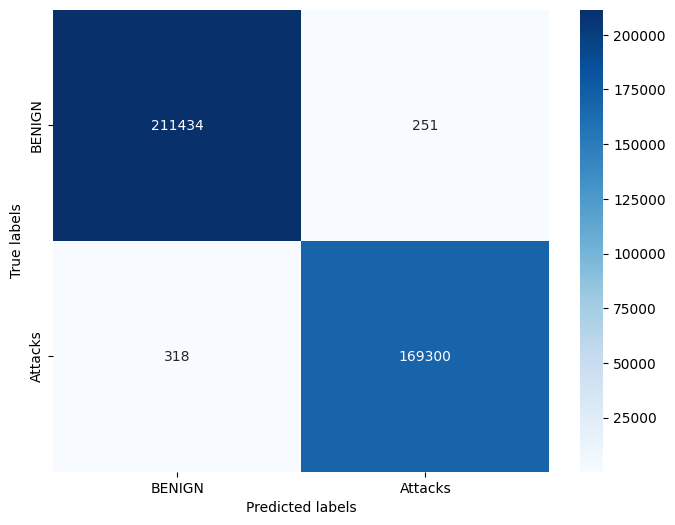

In [162]:
# Compute the confusion matrix for Decision Tree
cm_dt_fs_tunned = confusion_matrix(y_test, y_pred_dt)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt_fs_tunned, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Save confusion matrix fs

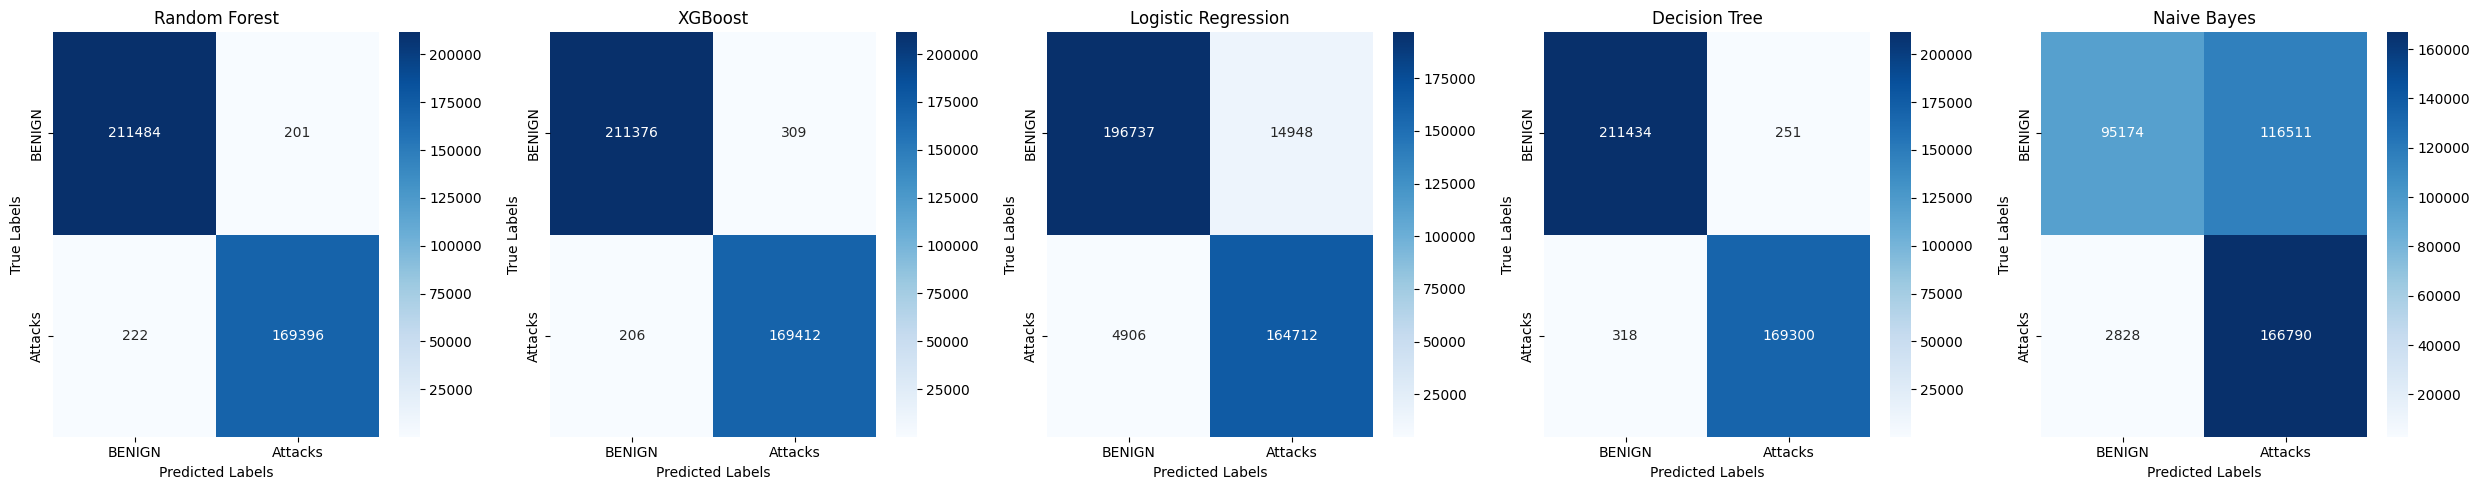

In [163]:
# Define the confusion matrices and titles in tuples for easier handling
confusion_matrices = [
    (cm_rfc_fs_tunned, "Random Forest"),
    (cm_xgb_fs_tunned, "XGBoost"),
    (cm_lr_fs_tunned, "Logistic Regression"),
    (cm_dt_fs_tunned, "Decision Tree"),
    (cm_nb_fs_tunned, "Naive Bayes")
]

# Setup the matplotlib figure and axes
num_matrices = len(confusion_matrices)
fig, axes = plt.subplots(nrows=1, ncols=num_matrices, figsize=(5 * num_matrices, 5))  # Adjust size as needed

# Check if only one row of subplots, make axes iterable
if num_matrices == 1:
    axes = [axes]

# Loop through the confusion matrices and corresponding axes
for ax, (cm, title) in zip(axes, confusion_matrices):
    # Plotting the confusion matrix using seaborn's heatmap function
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax, 
                xticklabels=['BENIGN', 'Attacks'], yticklabels=['BENIGN', 'Attacks'])
    ax.set_title(title)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

# Tight layout to ensure subplots do not overlap
plt.tight_layout()

# Save the figure
plt.savefig('all_confusion_matrices_fs.png')
plt.show()